In [1]:
import numpy as np
from netCDF4 import Dataset
from collections import Counter
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from minisom import MiniSom, asymptotic_decay
import xarray as xr
from itertools import product
import pandas as pd
from matplotlib.colors import TwoSlopeNorm
import glob


## Load Data

In [2]:
#Define coastline in CESM2
cesmcalicoast = np.zeros([27,8])
cesmcalicoast[8:12,1] = 1
cesmcalicoast[7,2] = 1
cesmcalicoast[6,2] = 1
cesmcalicoast[4:6,3] = 1
cesmcalicoast[3,4:6] = 1
cesmcalicoast[2,6] = 1
cesmpnwcoast = np.zeros([72,61])
cesmpnwcoast[20:28,44] = 1

[]

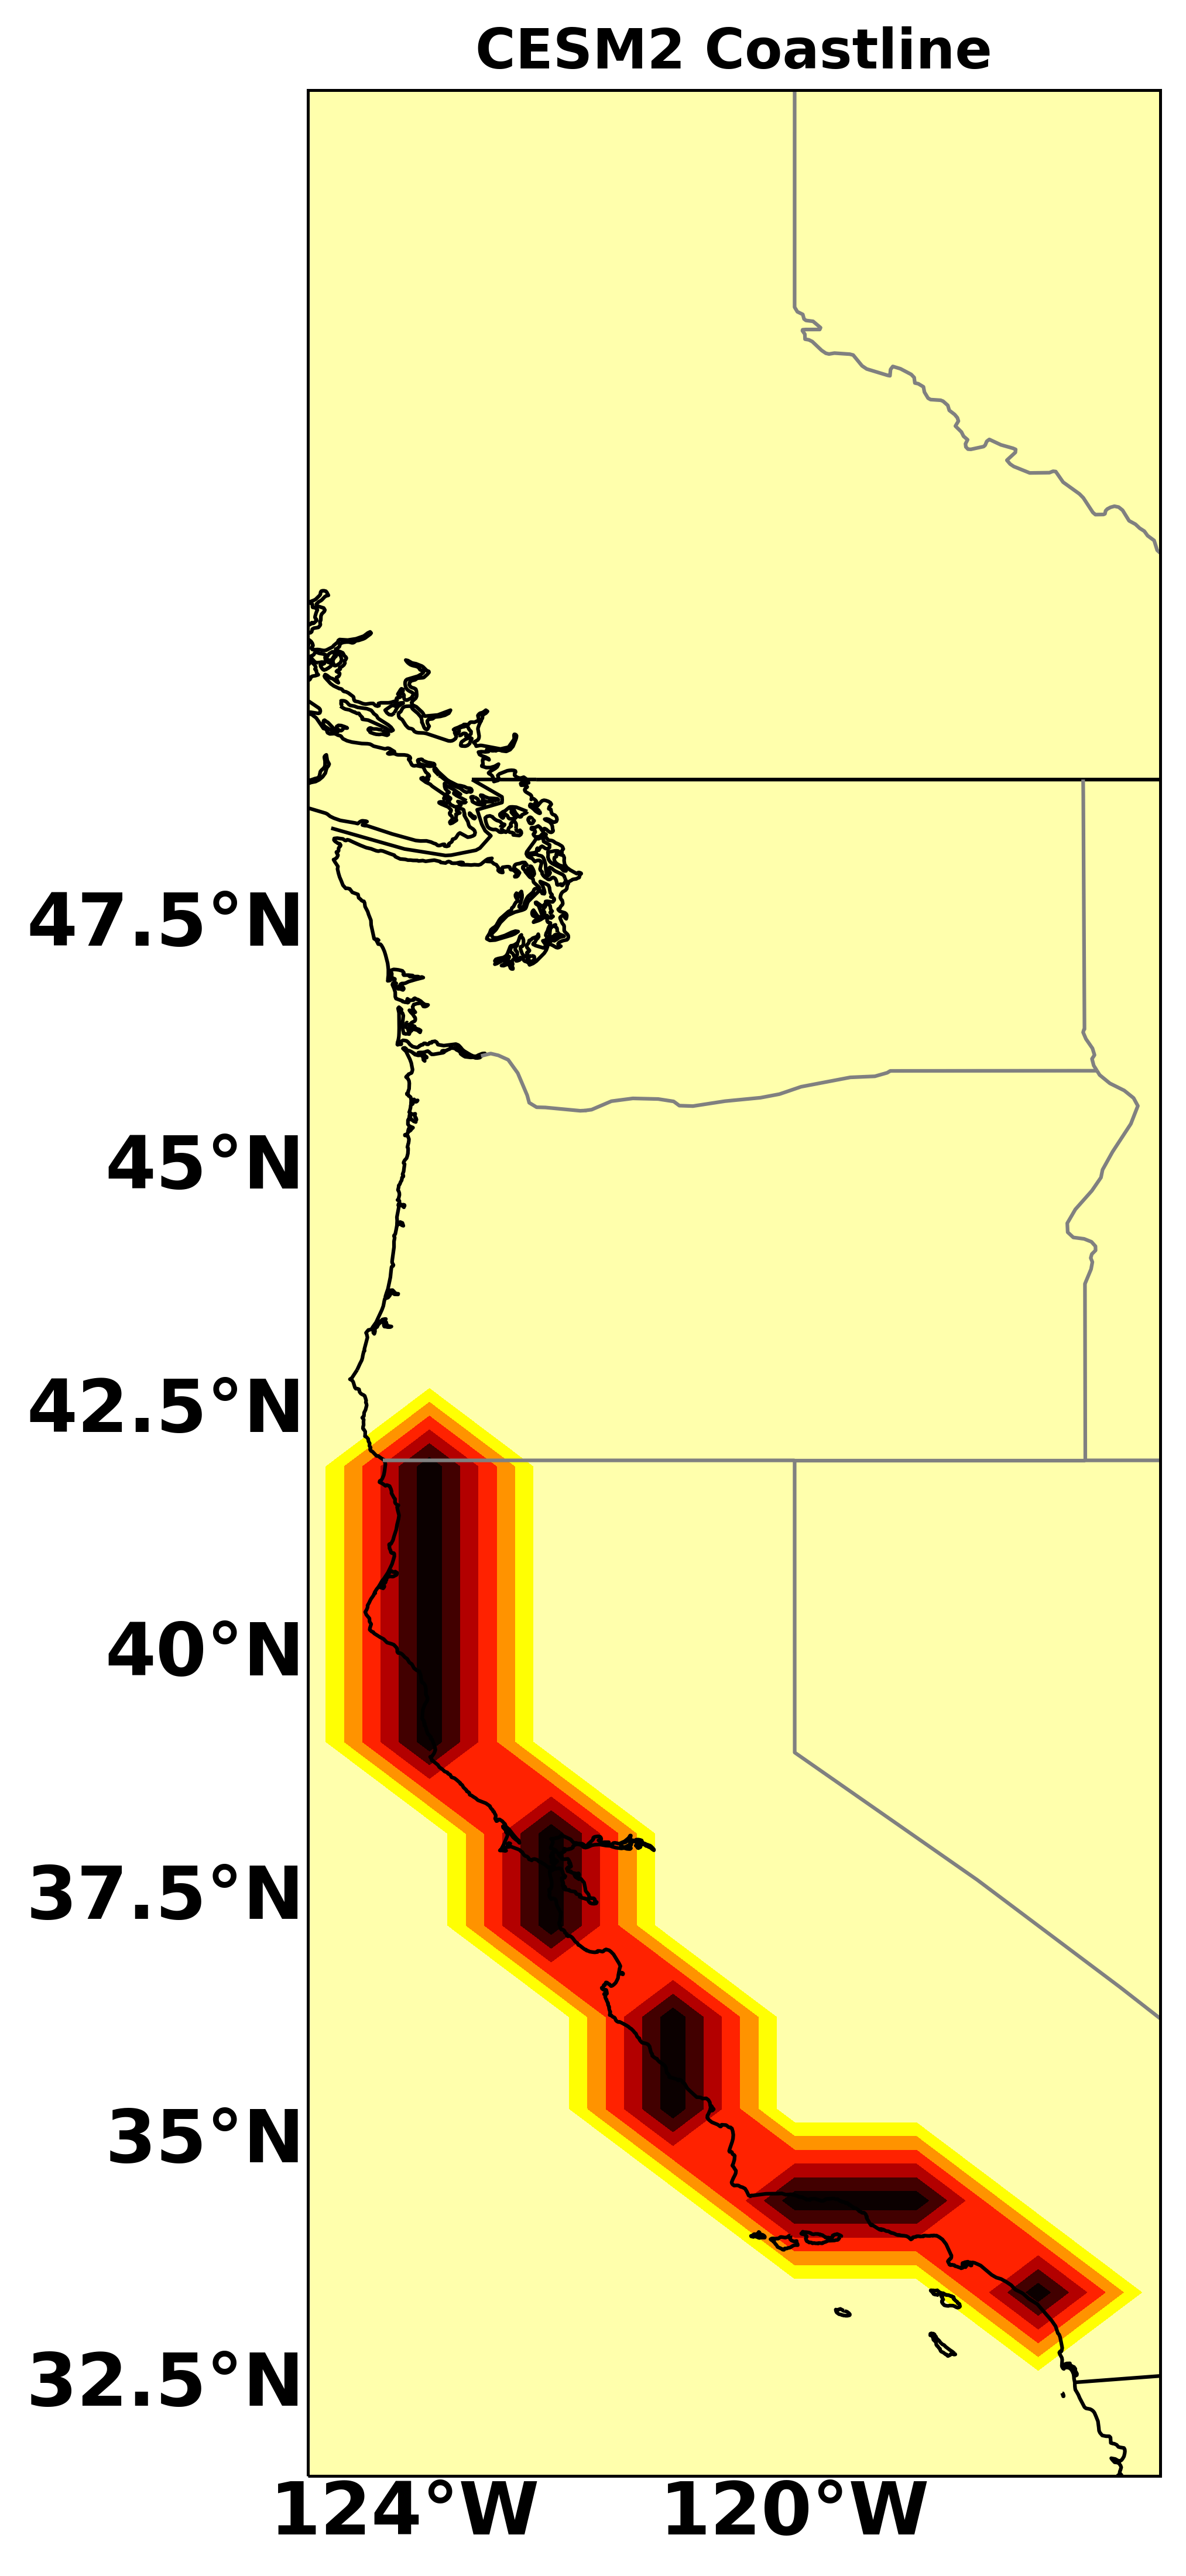

In [5]:
# view coastline
figure(num=None, figsize=(16, 12), dpi=450, facecolor='w', edgecolor='k')
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude= -102.5,globe=None))
colormap = plt.cm.get_cmap('hot') 
lat = Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/cesmhistmasks.nc').variables['lat'][:]
lon = Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/cesmhistmasks.nc').variables['lon'][:]

plt.contourf(lon[43:51],lat[9:36],cesmcalicoast[:],
			transform=ccrs.PlateCarree(),extend='max',cmap=colormap.reversed())


ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
states_provinces = cfeature.NaturalEarthFeature(
		category='cultural',
		name='admin_1_states_provinces_lines',
		scale='50m',
		facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
ax.add_feature(states_provinces, edgecolor='gray')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
				  linewidth=0, color='gray', alpha=0.5)
gl.xlabel_style = {'size': 20, 'weight': 'bold'}
gl.ylabel_style = {'size': 20, 'weight': 'bold'}
gl.xlocator = matplotlib.ticker.FixedLocator([-124,-120,-116,-112])
gl.ylocator = matplotlib.ticker.FixedLocator([32.5,35,37.5,40,42.5,45,47.5])

gl.xlabels_top = False
gl.ylabels_right = False

plt.title('CESM2 Coastline',weight = 'bold',fontsize = 15)
plt.plot()


In [14]:
# Load ARDT data and compute AR IWV in historical CESM
cmaskscesmhist = Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/cesmhistmasks.nc').variables['classmasks'][:,9:36,43:51]*cesmcalicoast
emaskscesmhist = Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/cesmhistmasks.nc').variables['eventmasks'][:,9:36,43:51]*cesmcalicoast #20:28,44
ariwvcesmhist = np.reshape(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/CESMhist.nc').variables['TMQ'][:,:,9:36,43:51],[2880*40,27,8])*cmaskscesmhist

In [7]:
# Load ARDT data and compute AR IWV in CESM SSP 3-7.0

cmasksssp370 = Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/cesmssp370masks.nc').variables['classmasks'][:,9:36,43:51]*cesmcalicoast
emasksssp370 = Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/cesmssp370masks.nc').variables['eventmasks'][:,9:36,43:51]*cesmcalicoast
ariwvssp370 = np.reshape(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/CESMssp370.nc').variables['TMQ'][:,:,9:36,43:51],[2880*50,27,8])*cmasksssp370

In [8]:
# Compute severity of all events
uniqueevents = np.unique(emasksssp370)
max_iwv = np.zeros([len(uniqueevents)-1])
i = 1
while i < len(uniqueevents):
	max_iwv[i-1] = np.max(ariwvssp370[emasksssp370==uniqueevents[i]])
	i+=1


In [10]:
# Compute return period for all events
i = 0
number_of_years = np.shape(emasksssp370)[0]/360
iwv_upper_limit1 = int(np.floor(np.max(max_iwv)))
calissp370cesm = np.zeros([iwv_upper_limit1])
while i < iwv_upper_limit1:
	calissp370cesm[i] = number_of_years/len(max_iwv[max_iwv>=i])
	i+=1

In [20]:
# Define coastline in HadAM4

whomecalicoast = np.zeros([17,9])
#whomecalicoast[17:29,0] = 1
whomecalicoast[12:17,0] = 1
whomecalicoast[10:12,1] = 1
whomecalicoast[7:10,2] = 1
whomecalicoast[6,3] = 1
whomecalicoast[3:6,4] = 1
whomecalicoast[3,4:6] = 1
whomecalicoast[2,6:8] = 1
whomecalicoast[0:2,8] = 1


In [ ]:
# Load data from HadAM4
cmasks = np.flip(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/whomehistmasks.nc').variables['classmasks'][:],axis=1)[:,31:43,67]
emasks = np.flip(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/whomehistmasks.nc').variables['eventmasks'][:],axis=1)[:,31:43,67]
ariwv = (np.reshape(np.flip(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/whomehist.nc').variables['IWV'][:],axis=2)[:,:,31:43,67],[2889*360,12]))*cmasks

In [10]:
# Reshape data and flip axes
cmasks = np.reshape(np.flip(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/whomehistmasks.nc').variables['classmasks'][:],axis=1)[:,14:31,67:76],[2889,360,17,9])*whomecalicoast
emasks = np.reshape(np.flip(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/whomehistmasks.nc').variables['eventmasks'][:],axis=1)[:,14:31,67:76],[2889,360,17,9])*whomecalicoast
ariwv = (np.flip(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/whomehist.nc').variables['IWV'][:],axis=2)[:,:,14:31,67:76])*cmasks

In [13]:
#Reshape CESM data for coastline computation (california only for easier computation)
cmasks = np.reshape(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/cesmhistmasks.nc').variables['classmasks'][:,9:36,43:51],[320,360,27,8])*cesmcalicoast
emasks = np.reshape(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/cesmhistmasks.nc').variables['eventmasks'][:,9:36,43:51],[320,360,27,8])*cesmcalicoast #20:28,44
ariwv = np.reshape(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/CESMhist.nc').variables['TMQ'][:,:,9:36,43:51],[320,360,27,8])*cmasks

In [24]:
#Reshape CESM data for coastline computation (PNW only for easier computation)
cmasks = np.reshape(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/cesmhistmasks.nc').variables['classmasks'][:,20:28,44],[320,360,8])
emasks = np.reshape(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/cesmhistmasks.nc').variables['eventmasks'][:,20:28,44],[320,360,8])
ariwv = np.reshape(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/CESMhist.nc').variables['TMQ'][:,:,20:28,44],[320,360,8])*cmasks

In [25]:
#Perform Bootstrapping
Num_samples = emasks.shape[0]
x = np.arange(emasks.shape[0])
number_of_years = np.shape(emasks)[0]/360

Nbs = 1000
P_Bootstrap=np.zeros([1000])
P_Bootstrap1=np.zeros([1000])
P_Bootstrap2=np.zeros([1000])

ii = 0
while ii< Nbs:
    idx = np.random.choice(x,Num_samples)
    max_iwv = []
    i = 0
    while i <  len(idx):
        j = 0
        uniqueevents = np.unique(emasks[idx[i],:,:])
        while j < len(uniqueevents):
            max_iwv.append(np.max(ariwv[idx[i],:,:][emasks[idx[i],:,:]==uniqueevents[j]]))
            j+=1
        i+=1
    P_Bootstrap[ii] = sorted(max_iwv)[(-1)*int(number_of_years)]
    P_Bootstrap1[ii] = sorted(max_iwv)[(-1)*int(number_of_years)/10]
    P_Bootstrap2[ii] = sorted(max_iwv)[np.round((-1)*int(number_of_years)/100)]
    ii+=1

In [26]:
#Compute 95% intervals
print(np.percentile(P_Bootstrap,97.5))
print(np.percentile(P_Bootstrap1,97.5))
print(np.percentile(P_Bootstrap2,97.5))
print(np.percentile(P_Bootstrap,2.5))
print(np.percentile(P_Bootstrap1,2.5))
print(np.percentile(P_Bootstrap2,2.5))

27.384016036987305
33.808441162109375
39.13874053955078
26.549612045288086
32.80809020996094
35.0400276184082


In [ ]:
uniqueevents = np.unique(emasks)
max_iwv = np.zeros([len(uniqueevents)-1])
i = 1
while i < len(uniqueevents):
    max_iwv[i-1] = np.max(ariwv[emasks==uniqueevents[i]])
    i+=1

In [ ]:
i = 0
number_of_years = np.shape(emasks)[0]/360
iwv_upper_limit = int(np.floor(np.max(max_iwv)))
caliwhomehist = np.zeros([iwv_upper_limit])
while i < iwv_upper_limit:
	caliwhomehist[i] = number_of_years/len(max_iwv[max_iwv>=i])
	i+=1

# recalculate for all scenarios and both models

## Figure 1

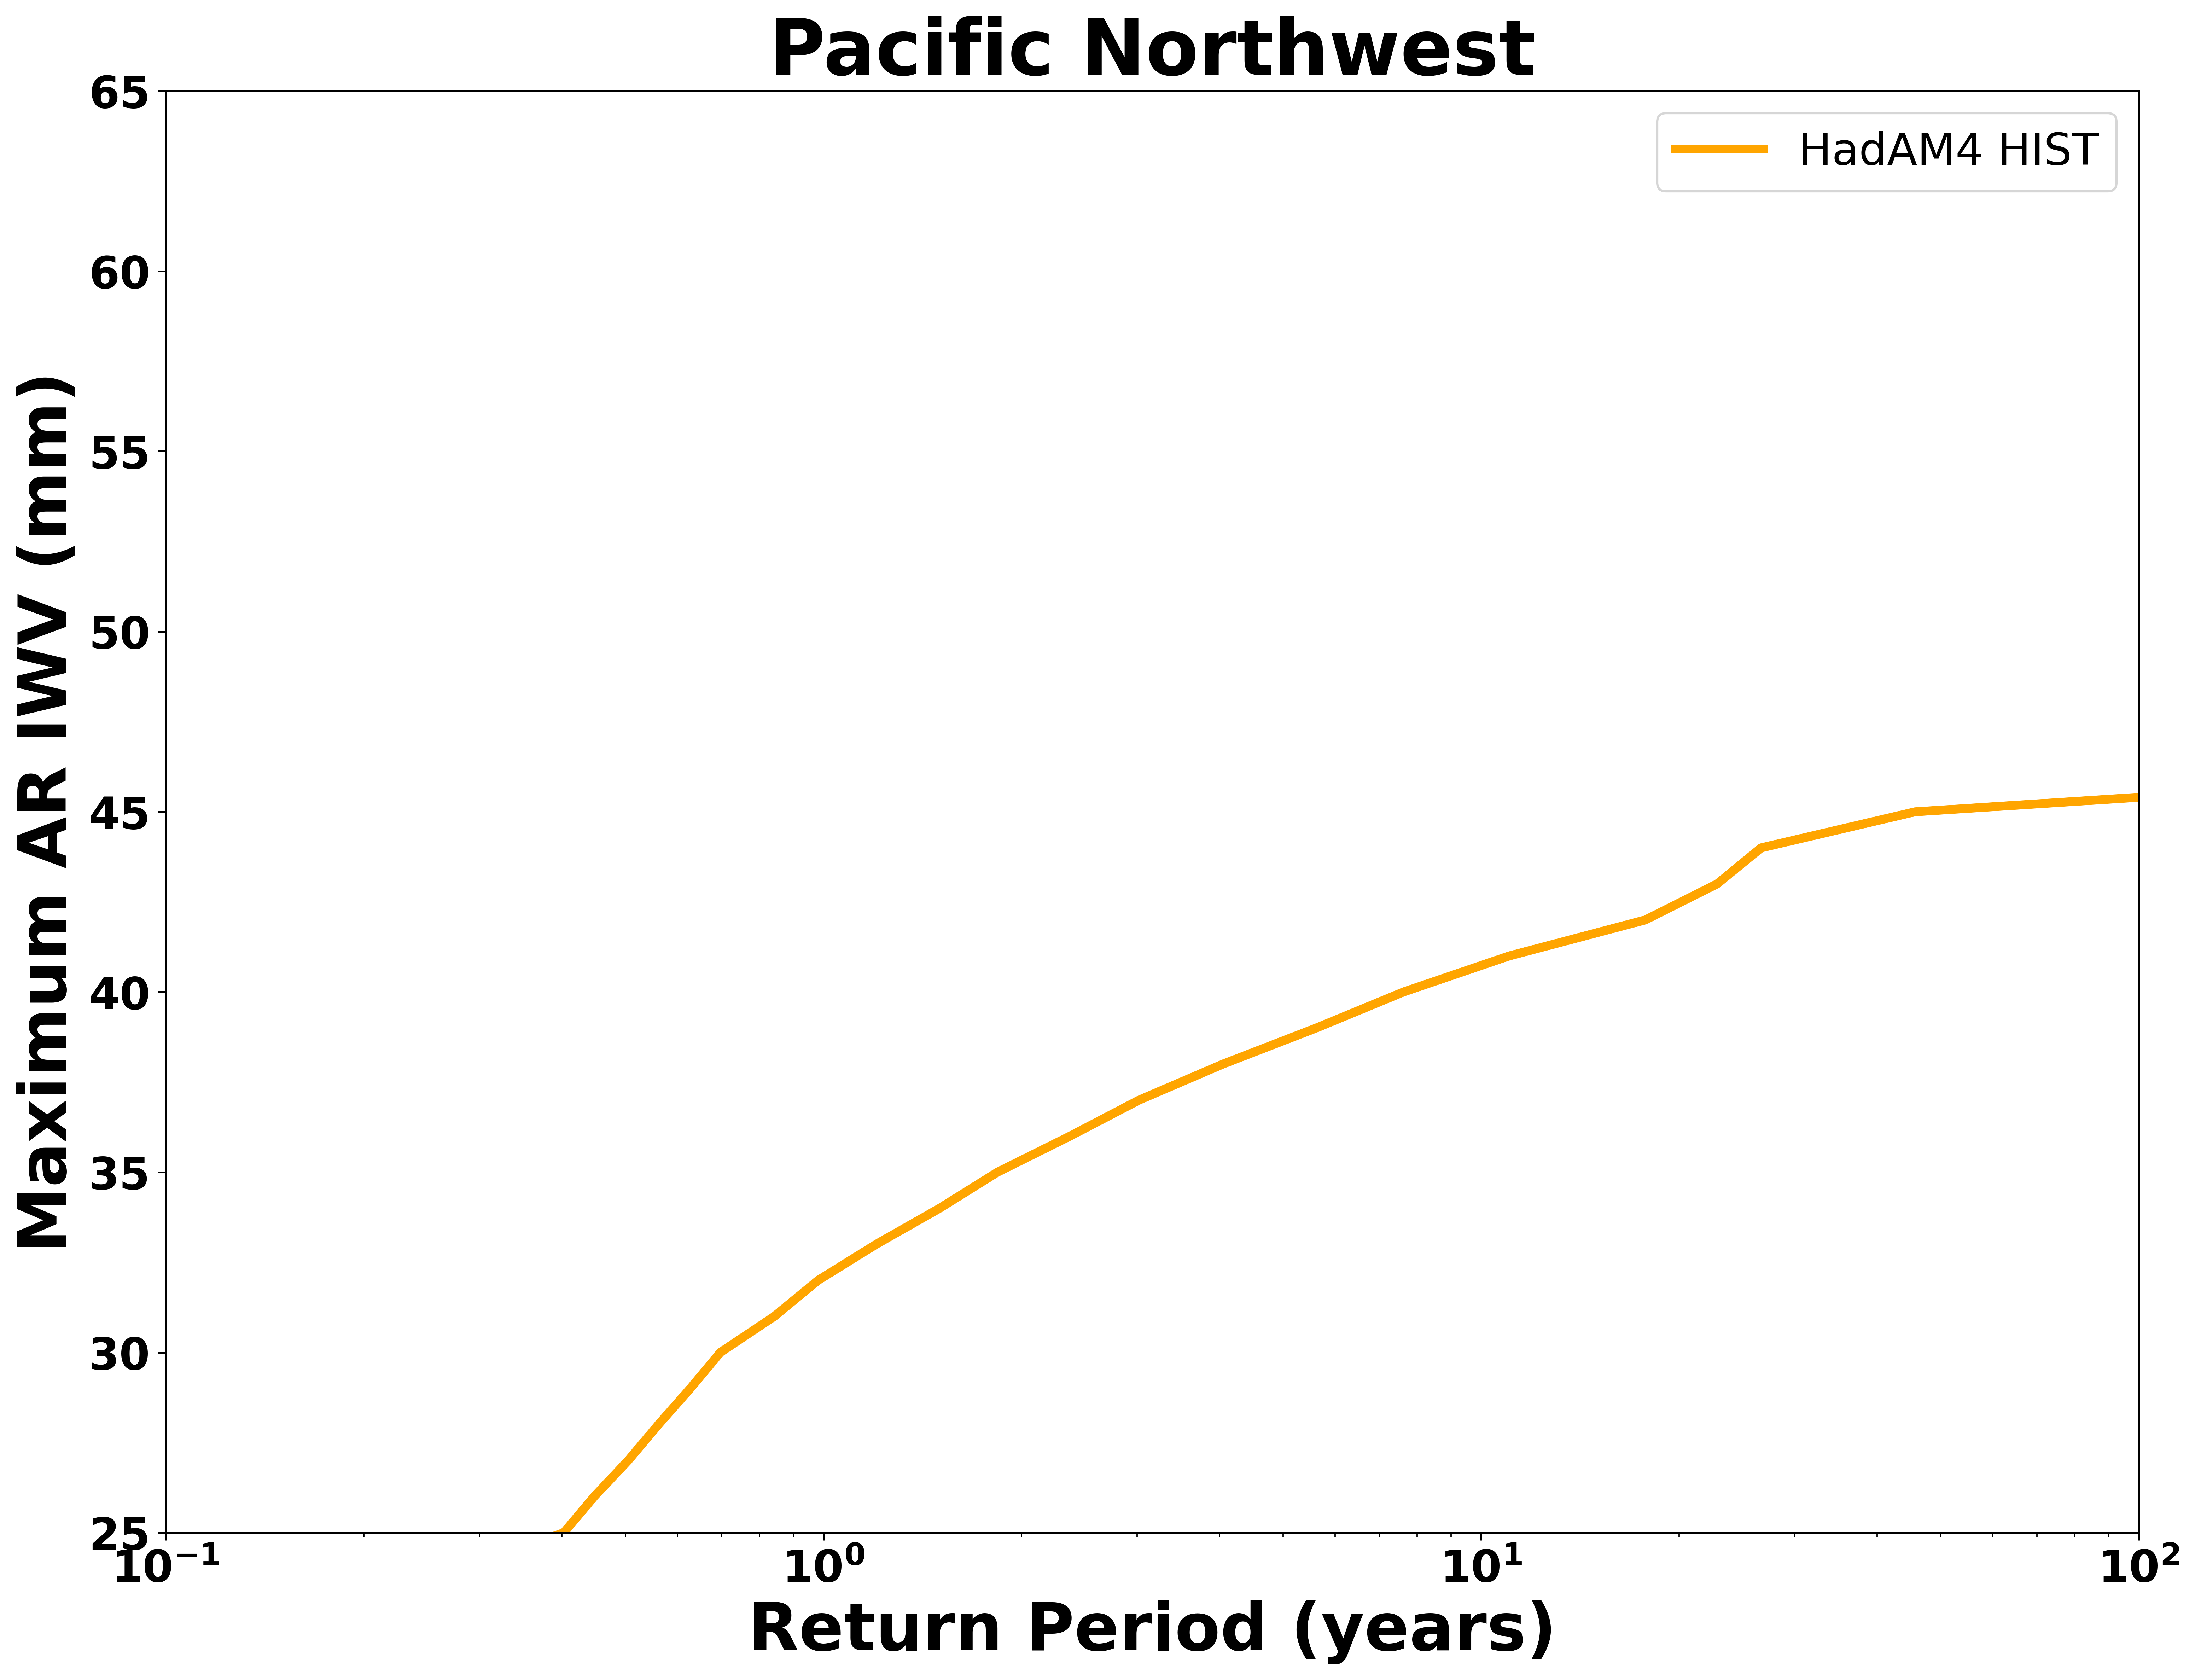

In [19]:
figure(num=None, figsize=(16, 12), dpi=450, facecolor='w', edgecolor='k')
xssp370 = np.arange(len(calissp370cesm))
xwhomehist = np.arange(len(caliwhomehist))


plt.plot(caliwhomehist,xwhomehist,linewidth = 4, label = "HadAM4 HIST", color = "Orange")
plt.plot(calissp370cesm,xssp370,linewidth = 4, label = "CESM SSP 3-7.0",color = "Blue")



plt.xscale("log")
plt.title("Pacific Northwest",weight='bold',size = 35)
plt.xlabel("Return Period (years)",weight='bold',size = 30)
plt.ylabel("Maximum AR IWV (mm)",weight='bold',size = 30)
plt.xlim([0.1,100])
plt.ylim([25,65])
plt.yticks(weight='bold',size = 20)
plt.xticks(weight='bold',size = 20)
plt.legend(prop={'size': 20})

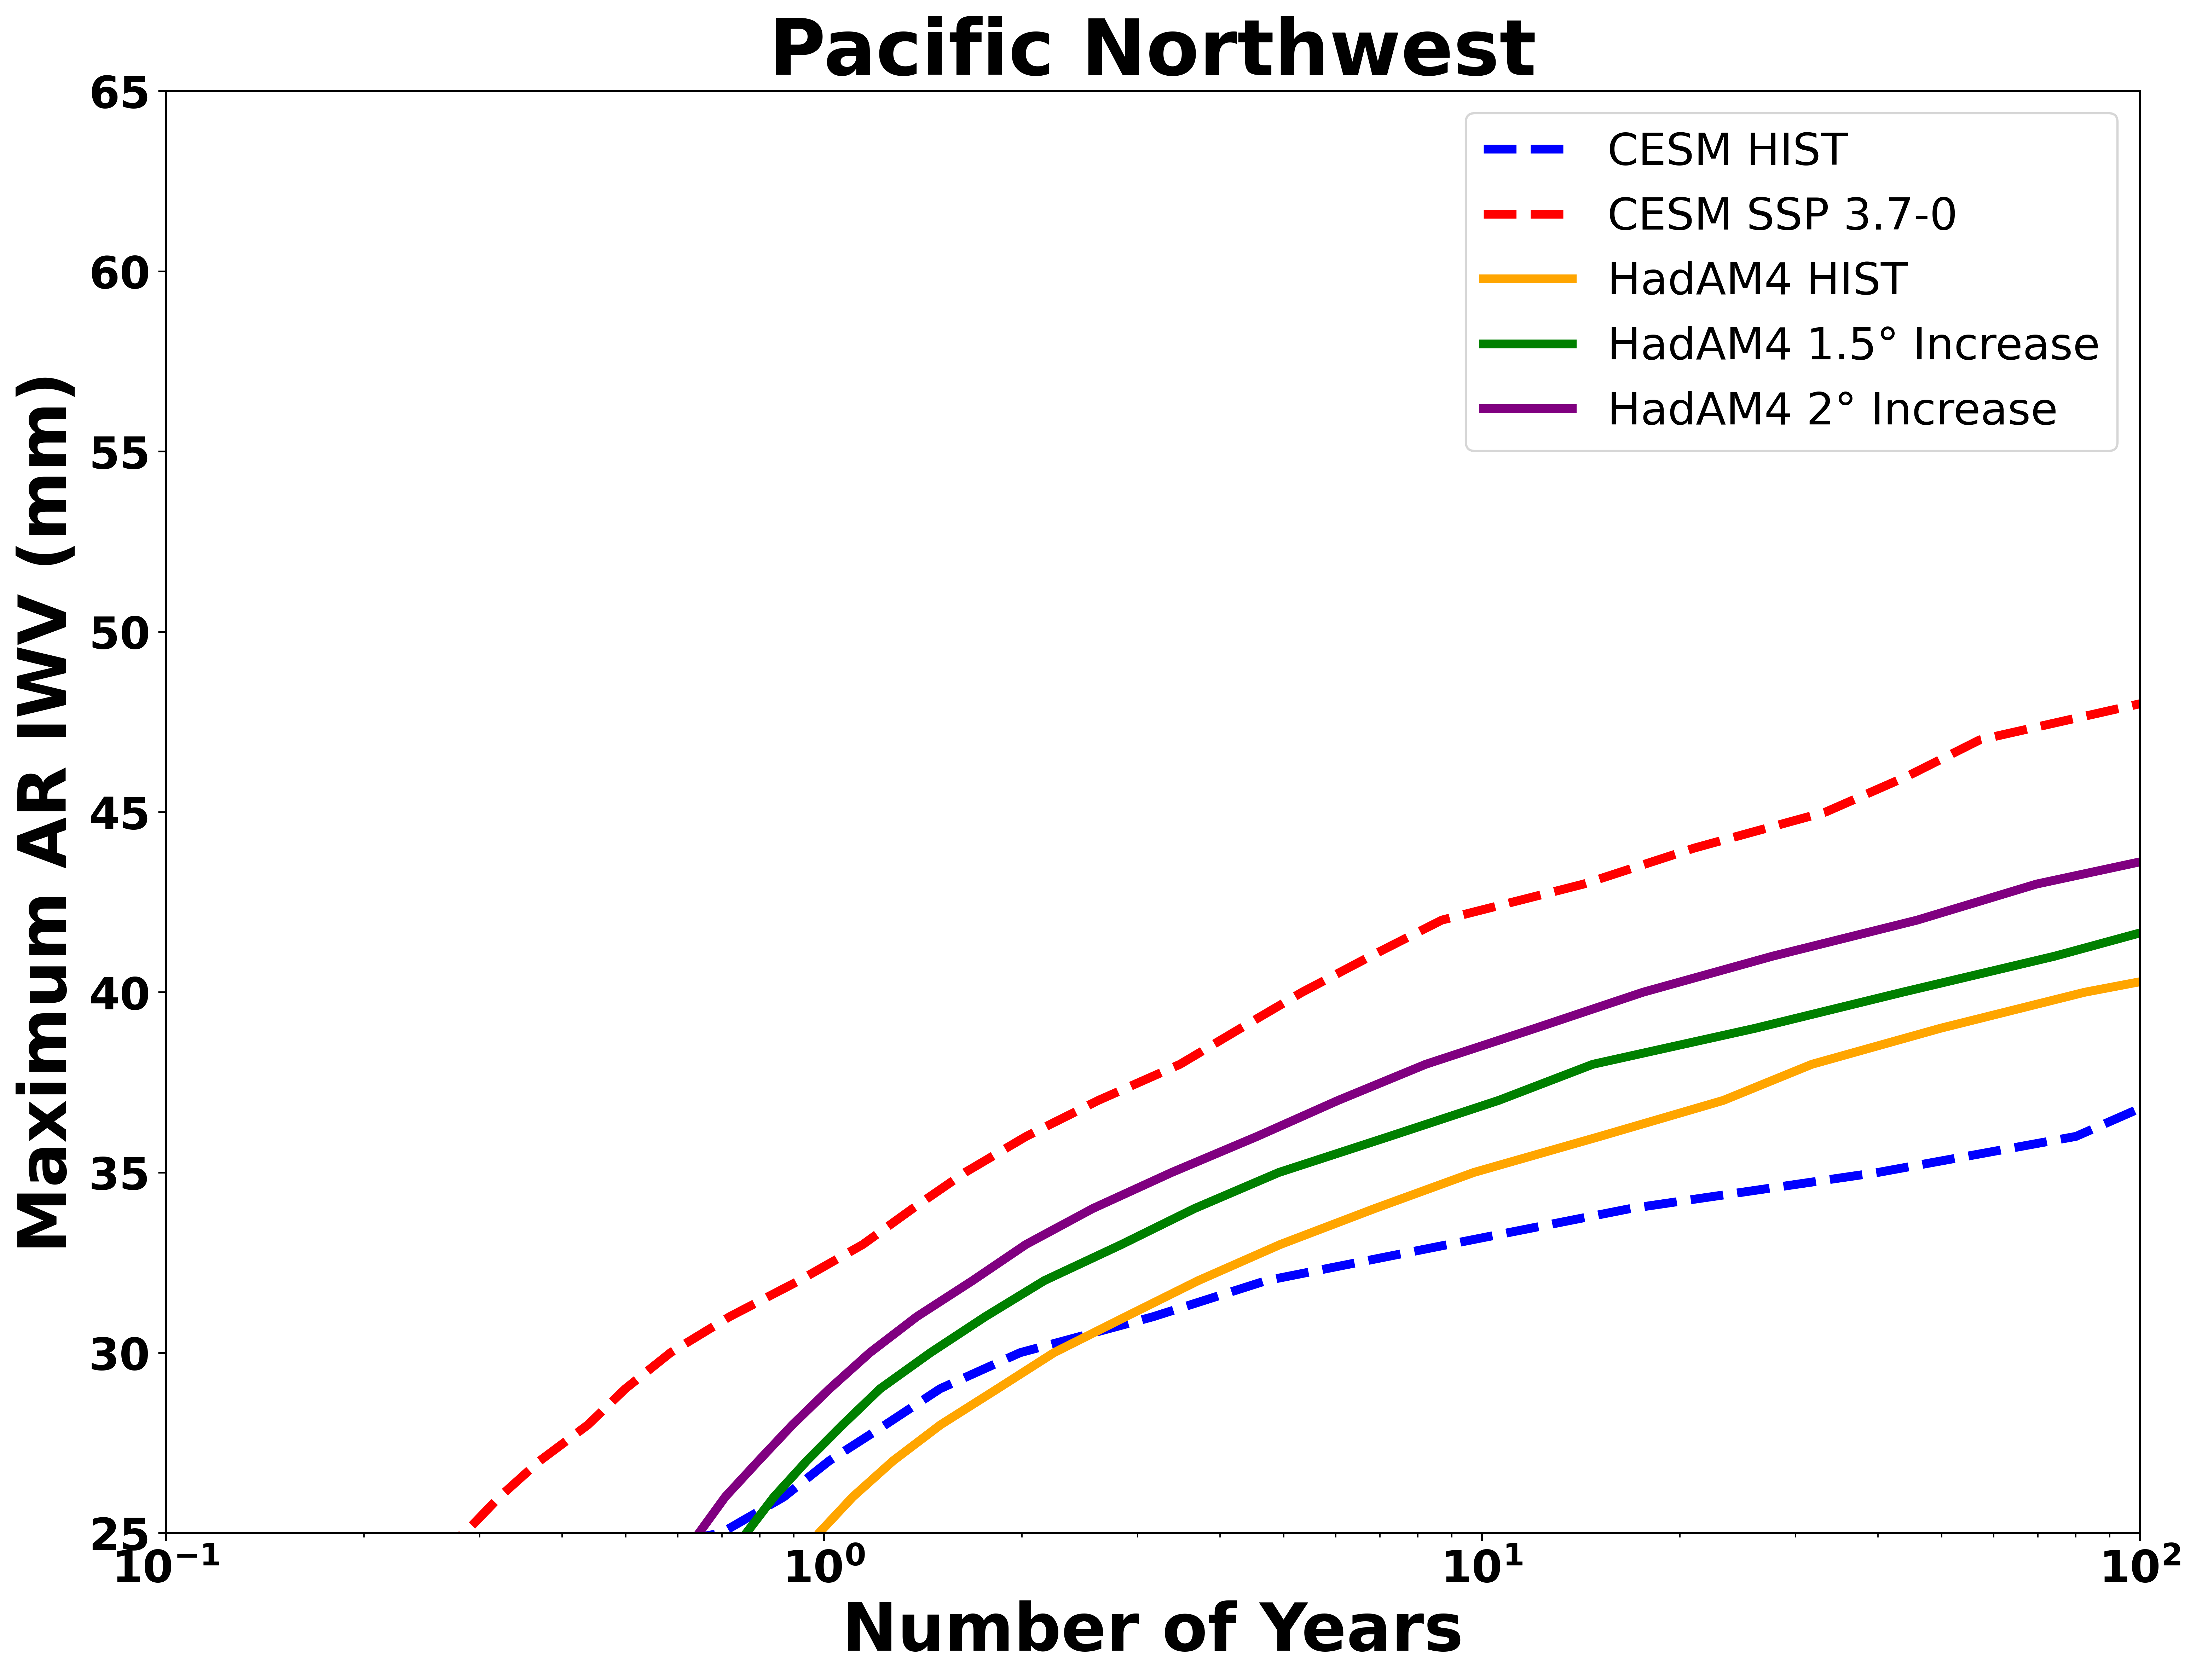

In [47]:
figure(num=None, figsize=(16, 12), dpi=450, facecolor='w', edgecolor='k')
#x = np.arange(iwv_upper_limit)
x1 = np.arange(len(caliwhomehist))
x = np.arange(len(calissp370cesm))
x3 = np.arange(len(caliwhome15))
x2 = np.arange(len(calihistcesm))
x4 = np.arange(len(caliwhome2))
plt.plot(calihistcesm,x2,linewidth = 4, label = "CESM HIST", color = "Blue",linestyle="--")
plt.plot(calissp370cesm,x,linewidth = 4, label = "CESM SSP 3.7-0", color = "Red",linestyle="--")
plt.plot(caliwhomehist,x1,linewidth = 4, label = "HadAM4 HIST", color = "Orange")

plt.plot(caliwhome15,x3,linewidth = 4, label = "HadAM4 1.5° Increase", color = "Green")

plt.plot(caliwhome2,x4,linewidth = 4, label = "HadAM4 2° Increase", color = "Purple")



plt.xscale("log")
plt.title("Pacific Northwest",weight='bold',size = 35)
plt.xlabel("Return Period (years)",weight='bold',size = 30)
plt.ylabel("Maximum AR IWV (mm)",weight='bold',size = 30)
plt.xlim([0.1,100])
plt.ylim([25,65])
plt.yticks(weight='bold',size = 20)
plt.xticks(weight='bold',size = 20)
plt.legend(prop={'size': 20})

In [31]:
# Find distribution of rare extremes by season

seasonal_events = np.zeros([int(number_of_years)])
i = 0
while i < int(number_of_years):
	idx = np.where(np.max(ariwv[i*360:(i+1)*360,:],axis=1)>sorted(max_iwv)[(-1)*int(number_of_years)])[0]
	seasonal_events[i] = len(np.unique(emasks[i*360:(i+1)*360,:][idx,:]))
	i+=1
Seasonaliwvwhomepnwhist = Counter(seasonal_events)

In [ ]:
#np.unique should return a two when one extreme event is found because it will also find zeros
#repeat the process for all scenarios and for CESM2
whomehistiwv = np.array([Seasonaliwvwhomepnwhist[0],Seasonaliwvwhomepnwhist[2],Seasonaliwvwhomepnwhist[3],Seasonaliwvwhomepnwhist[4],Seasonaliwvwhomepnwhist[5],Seasonaliwvwhomepnwhist[6],Seasonaliwvwhomepnwhist[7],Seasonaliwvwhomepnwhist[8],Seasonaliwvwhomepnwhist[9]])*100/number_of_years

## Figure 2

(-40.0, 40.0)

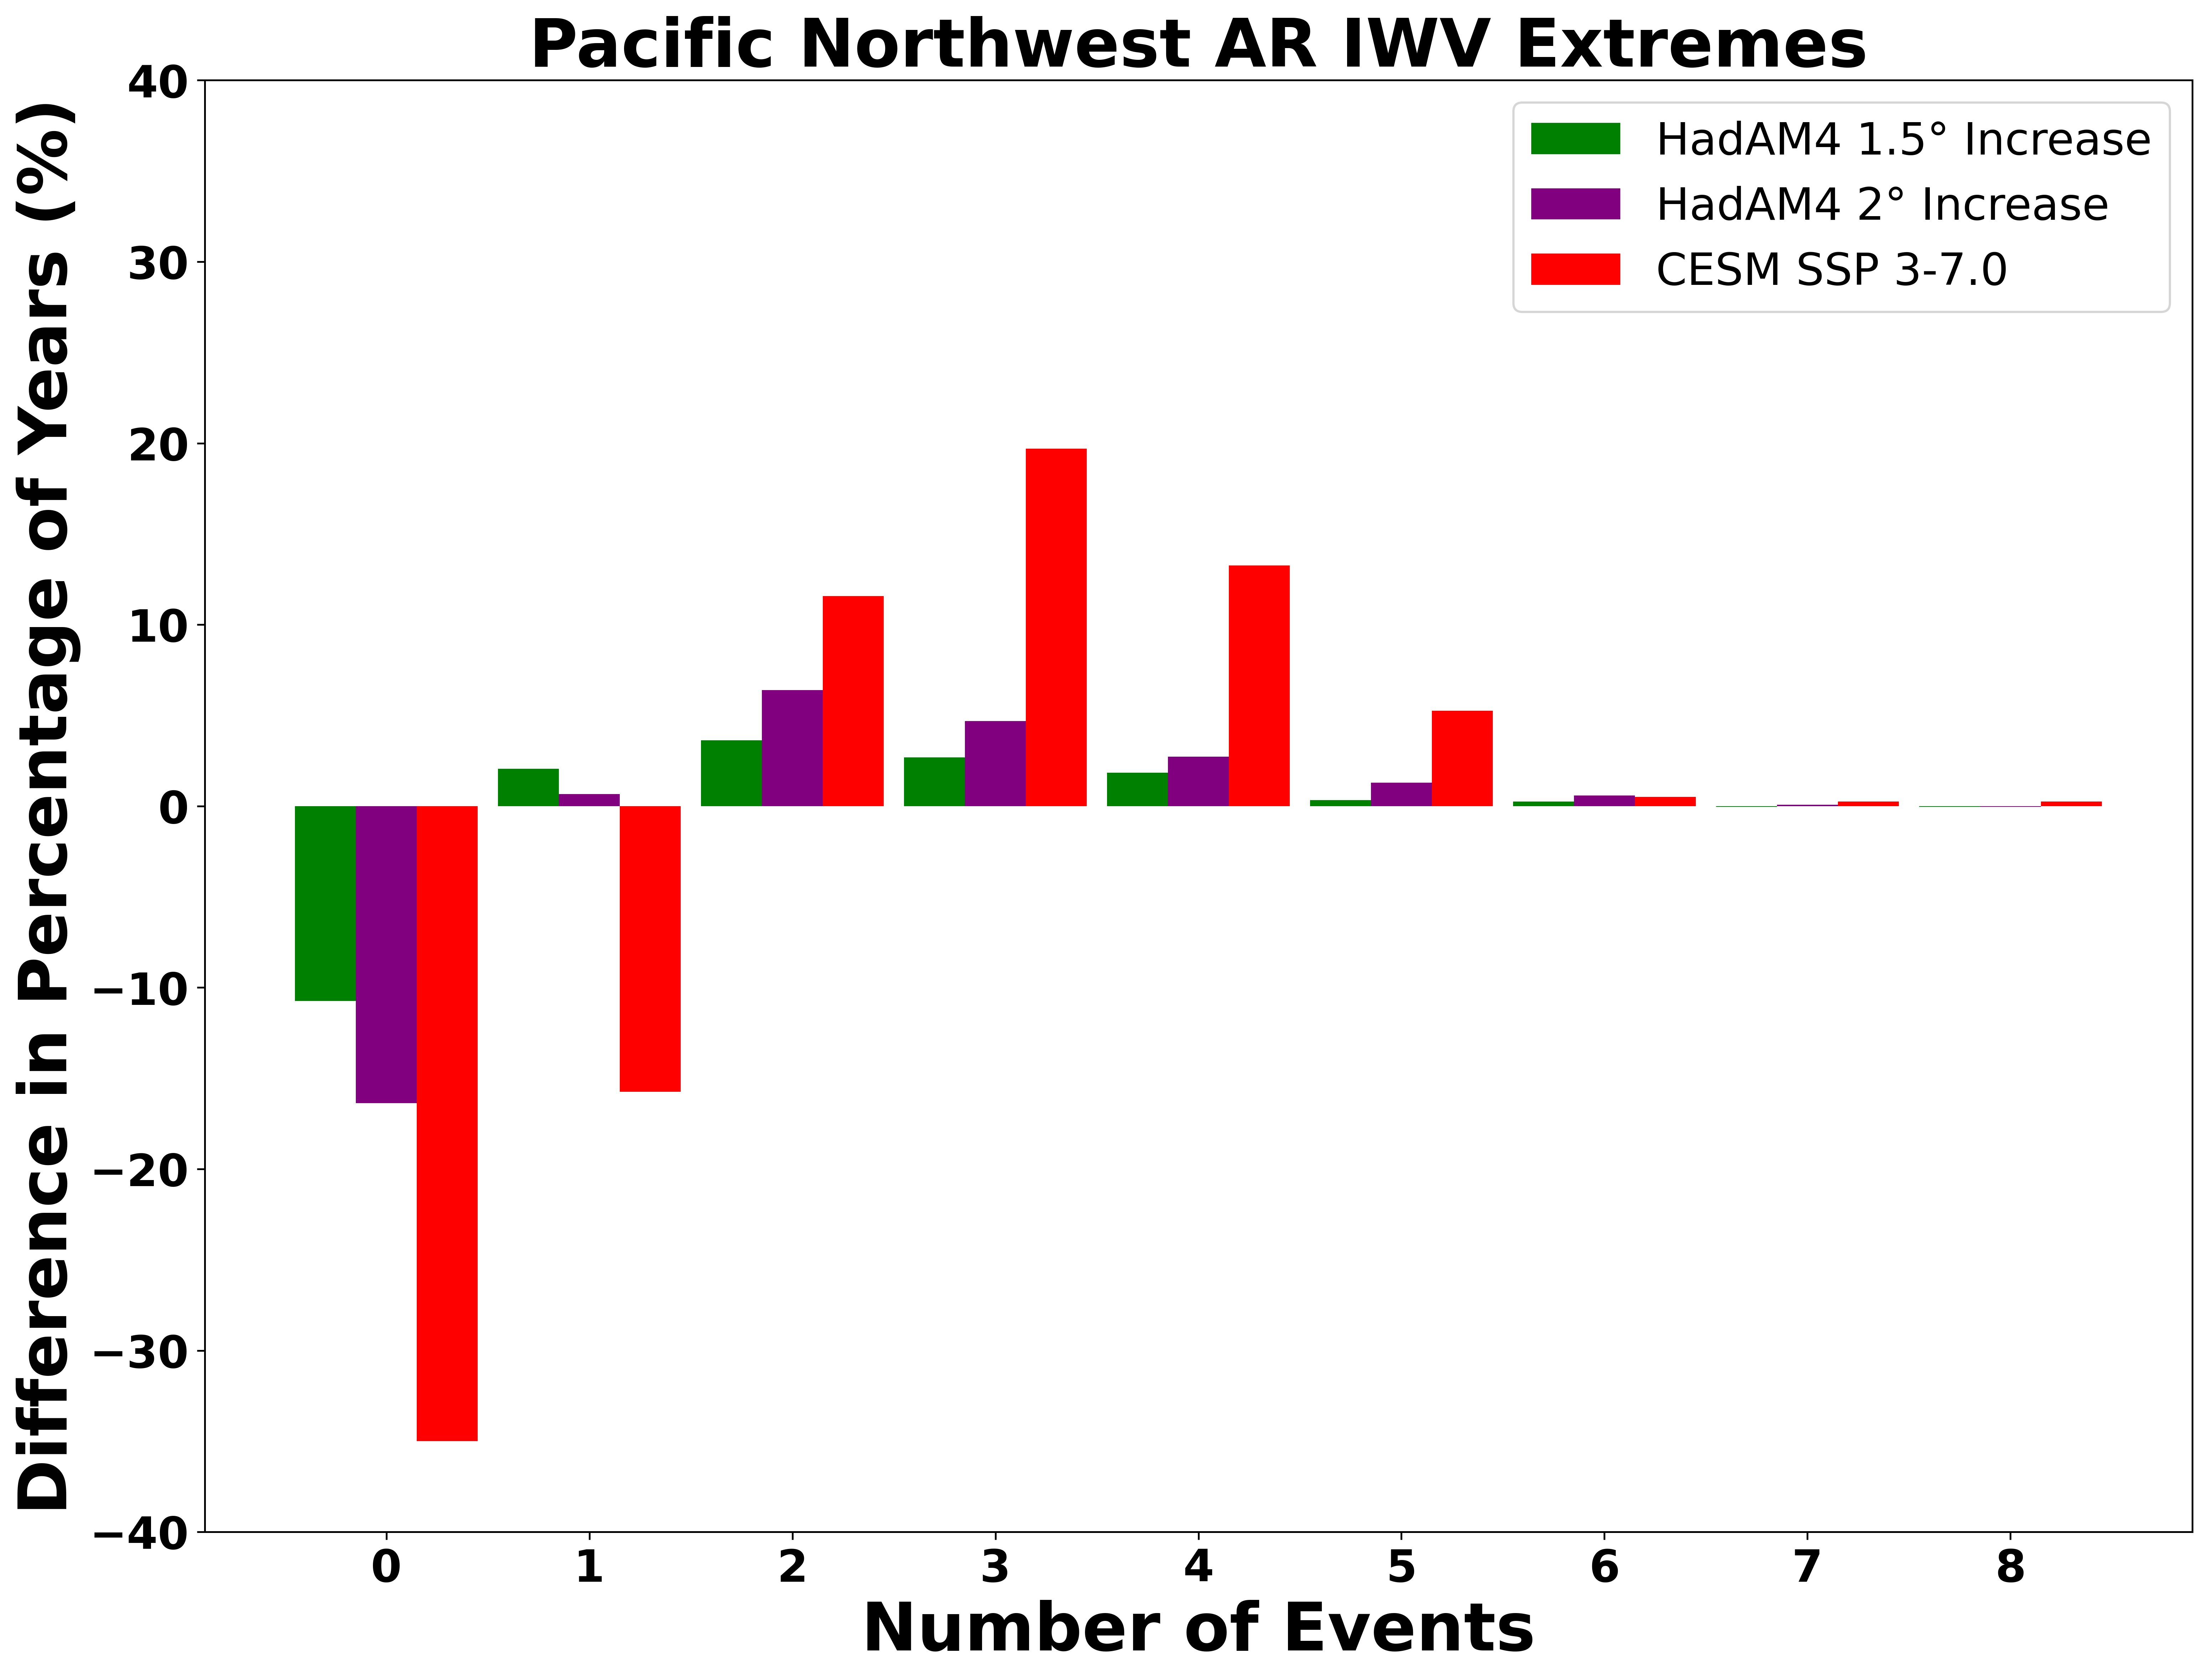

In [3]:
figure(num=None, figsize=(16, 12), dpi=450, facecolor='w', edgecolor='k')

x = np.arange(9)

plt.bar(x-.3,np.array(whome15ciwv)-np.array(whomehistiwv),.3,label = "HadAM4 1.5° Increase",color='Green')

plt.bar(x,np.array(whome2ciwv)-np.array(whomehistiwv),.3,label = "HadAM4 2° Increase",color='Purple')

plt.bar(x+.3,np.array(cesmssp370iwv)-np.array(cesmhistiwv),.3,label = "CESM SSP 3-7.0",color='Red')

plt.ylabel('Difference in Percentage of Years (%)',weight='bold',size = 30)
plt.xlabel('Number of Events',weight='bold',size = 30)
plt.title('Pacific Northwest AR IWV Extremes',weight='bold',size=30)
plt.yticks(weight='bold',size = 20)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8],weight='bold',size = 20)
plt.legend(prop={'size': 20})
plt.ylim([-40,40])

In [ ]:
window_size = 20
p1 = np.reshape(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/whomehist.nc').variables['PSL'][:,:,:,:],[2889*360,118,95])
p2 = np.reshape(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/whome1_5c.nc').variables['PSL'][:,:,:,:],[2006*360,118,95])
p3 = np.reshape(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/whome2c.nc').variables['PSL'][:,:,:,:],[1882*360,118,95])
p = np.concatenate([p1,p2,p3],axis=0)
psm = np.apply_along_axis(lambda x: np.convolve(x, np.ones(window_size)/window_size, mode='same'), axis=1, arr=p)
psm = np.flip(psm,axis=1)
ds = xr.DataArray(psm,dims=["time","lat","lon"])
psm = ds.to_netcdf('/glade/derecho/scratch/timothyh/data/MSLP_SOMsm5daywhome.nc')

In [2]:
ds = xr.open_dataarray('/glade/derecho/scratch/timothyh/data/MSLP_SOMsm5daywhome.nc')

In [3]:
subset = ds.where(
         (ds['lat']<50) & (ds['lat']>0) & \
         (ds['lon']>-10) & (ds['lon']<60), 
         drop=True)
subset.stack(new=("lat","lon")).shape

(2439720, 2940)

In [4]:
subsetarray = subset.stack(new=("lat","lon")).values

In [81]:
som_grid_rows = 1          # (y-axis)
som_grid_columns = 5        # (x-axis)
input_length = subsetarray.shape[1]    # using preprocessed data array; Number of the elements of the vectors in input.
sigma = 0.5               # Spread of the neighborhood function, needs to be adequate to the dimensions of the map.
learning_rate = 0.5       # initial learning rate (at the iteration t we have learning_rate(t) = learning_rate / (1 + t/T) where T is #num_iteration/2)
decay_function = asymptotic_decay

"""Function that reduces learning_rate and sigma at each iteration
    the default function is (asymptotic_decay):
                learning_rate / (1+t/(max_iterarations/2))

    A custom decay function will need to to take in input
    three parameters in the following order:

    1. learning rate
    2. current iteration
    3. maximum number of iterations allowed

    Note that if a lambda function is used to define the decay
    MiniSom will not be pickable anymore."""

neighborhood_function = 'gaussian'

"""Function that weights the neighborhood of a position in the map. 
    Possible values: 'gaussian', 'mexican_hat', 'bubble', 'triangle', 
    which takes in sigma."""

topology = 'rectangular'                 # Topology of the map; Possible values: 'rectangular', 'hexagonal'
activation_distance = 'euclidean'        # Distance used to activate the map; Possible values: 'euclidean', 'cosine', 'manhattan', 'chebyshev'
random_seed = 1              

In [82]:
som = MiniSom(
            som_grid_rows,
            som_grid_columns,
            input_length,
            sigma,
            learning_rate,
            decay_function,
            neighborhood_function,
            topology,
            activation_distance,
            random_seed) 

In [7]:
def normalize_data(data):
    """
    Function for normalizing data prior to training using z-score
    """
    return (data - np.nanmean(data)) / np.nanstd(data)

In [8]:
data = normalize_data(subsetarray)
num_iteration = 100000
random_order = True
verbose = True

In [83]:
som.train(
        data,
        num_iteration,
        random_order,
        verbose)

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 4.567710710269939


In [84]:
keys = [i for i in product(range(som_grid_rows),range(som_grid_columns))]
winmap = {key: [] for key in keys}

# grab the indices for the data within the SOM lattice
for i, x in enumerate(data):
    winmap[som.winner(x)].append(i)

In [85]:
som_keys = list(winmap.keys())


In [92]:
len(winmap[som_keys[0]])

613805

In [93]:
idx1 = winmap[som_keys[0]]
idx2 = winmap[som_keys[1]]
idx3 = winmap[som_keys[2]]
idx4 = winmap[som_keys[3]]
idx5 = winmap[som_keys[4]]

da1 = xr.DataArray(data = idx1, dims=['num'],
                           coords={'num': list(np.arange(len(idx1)))},
                                    name = "idx1")
da2 = xr.DataArray(data = idx2, dims=['num'],
                           coords={'num': list(np.arange(len(idx2)))},
                                    name = "idx2")
da3 = xr.DataArray(data = idx3, dims=['num'],
                           coords={'num': list(np.arange(len(idx3)))},
                                    name = "idx3")
da4 = xr.DataArray(data = idx4, dims=['num'],
                           coords={'num': list(np.arange(len(idx4)))},
                                    name = "idx4")
da5 = xr.DataArray(data = idx5, dims=['num'],
                           coords={'num': list(np.arange(len(idx5)))},
                                    name = "idx5")

da = xr.merge([da1,da2,da3,da4,da5])
outdir = '/glade/work/timothyh/data/'

da.to_netcdf(outdir+"whomecalculatedsomsfiltered5day.nc")

In [2]:
psm = Dataset('/glade/derecho/scratch/timothyh/data/MSLP_SOMsm5daywhome.nc').variables['__xarray_dataarray_variable__'][:]
psmanom = psm-np.mean(psm,axis=0)

In [36]:
idx1 = np.array(Dataset('/glade/work/timothyh/data/whomecalculatedsomsfiltered5day.nc').variables['idx5'][:])
idx1 = idx1[~np.isnan(idx1)].astype(int)

## Figure 3

/glade/work/timothyh/miniconda3/envs/analysis/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/timothyh/miniconda3/envs/analysis/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


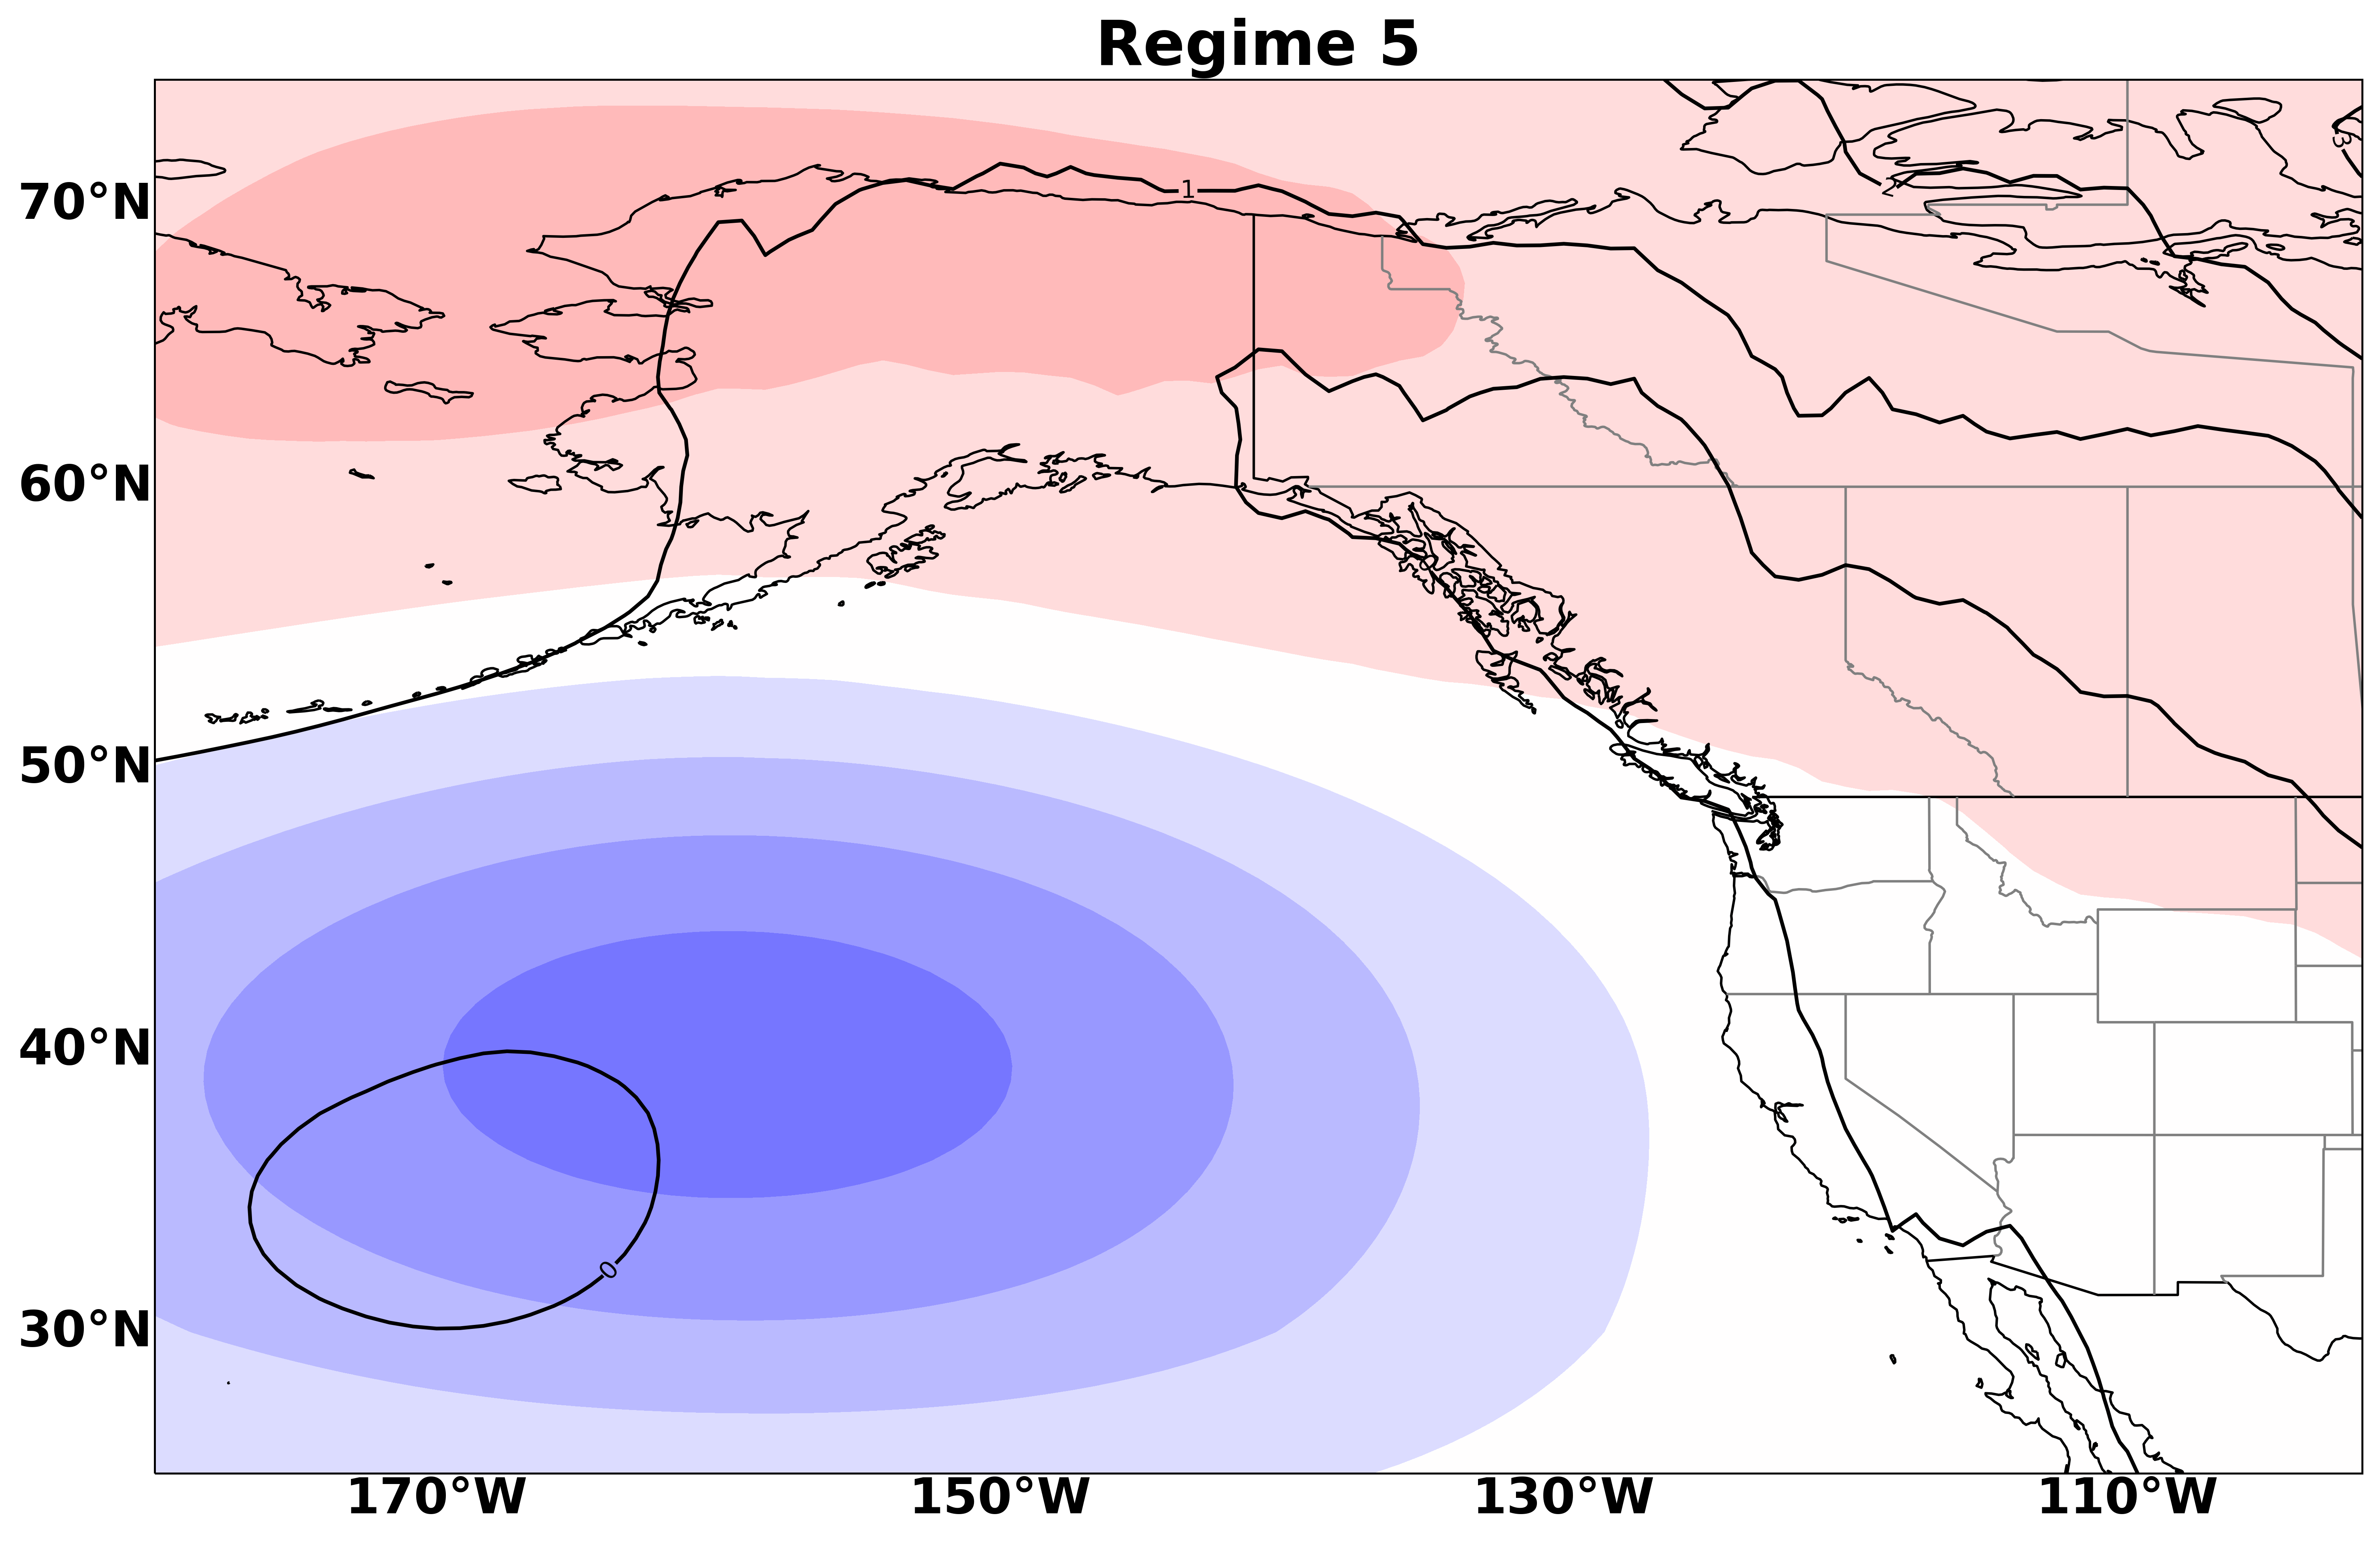

In [22]:
f1 = '/glade/derecho/scratch/timothyh/data/weatherhome/completed/whomehist.nc'
conlevels = np.linspace(-30,30,num=16)
clevs = [-.25,-.05,.05,.25,.45,.65,.85,1.05,1.25]
lat = Dataset(f1).variables['lat'][:]
lon = Dataset(f1).variables['lon'][:]
figure(num=None, figsize=(16, 12), dpi=450, facecolor='w', edgecolor='k')
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude= -102.5,globe=None))
colormap = plt.cm.get_cmap('bwr') 

plt.contourf(lon[:],lat[:90],np.mean(psmanom[idx1,:90,:],axis=0)/100,conlevels,
			transform=ccrs.PlateCarree(), extend = 'both',cmap=colormap)
cs = ax.contour(lon[:],lat[:90],(np.mean(psm[idx1[idx1<1040040],:90,:],axis=0)-(np.mean(psm[idx1[idx1>1762200],:90,:],axis=0)))/100,clevs,
			transform=ccrs.PlateCarree(),colors = 'black')
def fmt(x):
	s = f"{x:.1f}"
	if s.endswith("0"):
		s = f"{x:.0f}"
	return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
states_provinces = cfeature.NaturalEarthFeature(
		category='cultural',
		name='admin_1_states_provinces_lines',
		scale='50m',
		facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
ax.add_feature(states_provinces, edgecolor='gray')
ax.set_ylim(top=74)
#cbar = plt.colorbar(orientation='horizontal',ticks=[-30,-18,-6,6,18,30])
#cbar.ax.set_xlabel('MSLP Anomaly (mb)', fontsize = 25,rotation=0,weight='bold')
#cbar.ax.tick_params(labelsize=20) 

#ax.clabel(cs,[-2,-1,0,1,2], inline=True, fmt=fmt, fontsize=10)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
				  linewidth=0, color='gray', alpha=0.5)
gl.xlabel_style = {'size': 20, 'weight': 'bold'}
gl.ylabel_style = {'size': 20, 'weight': 'bold'}
#gl.xlocator = ticker.FixedLocator([-135,-120])
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = matplotlib.ticker.FixedLocator([-190,-170,-150,-130,-110])
gl.ylocator = matplotlib.ticker.FixedLocator([30,40,50,60,70])
ax.clabel(cs,[-5,-4,-3,-2,-1,0,1,2,3,4,5], inline=True, fmt=fmt, fontsize=10)

plt.title('Regime 1',weight = 'bold',fontsize = 25)#1.5\N{DEGREE SIGN}C Increase')
plt.plot()
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [4]:
cmaskshist = np.flip(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/whomehistmasks.nc').variables['classmasks'][:],axis=1)[:,14:46,67:76]*whomecalicoast
#ariwvhist = (np.reshape(np.flip(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/whomehist.nc').variables['IWV'][:],axis=2)[:,:,14:46,67:76],[2889*360,32,9]))*cmaskshist

#cmasks15 = np.flip(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/whome1_5masks.nc').variables['classmasks'][:],axis=1)[:,14:46,67:76]*whomecalicoast
#ariwv15 = (np.reshape(np.flip(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/whome1_5c.nc').variables['IWV'][:],axis=2)[:,:,14:46,67:76],[2006*360,32,9]))*cmasks15

cmasks2 = np.flip(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/whome2masks.nc').variables['classmasks'][:],axis=1)[:,14:46,67:76]*whomecalicoast
#ariwv2 = (np.reshape(np.flip(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/whome2c.nc').variables['IWV'][:],axis=2)[:,:,14:46,67:76],[1882*360,32,9]))*cmasks2
#ariwv = np.concatenate([ariwvhist,ariwv15,ariwv2],axis=0)

In [21]:
idx = np.where(np.max(ariwv,axis=(1,2))>sorted(max_iwv)[(-1)*int(number_of_years))

In [22]:
#save locations in data of extreme events
ds = xr.DataArray((idx[0]))
ds.to_netcdf('/glade/work/timothyh/data/coastextremeidx.nc')

In [9]:
(2889*360)+(2006*360)

1762200

In [41]:
xars = Dataset('/glade/work/timothyh/data/coastextremeidx.nc').variables['__xarray_dataarray_variable__'][:]

idxregime = Dataset('/glade/work/timothyh/data/whomecalculatedsomsfiltered5day.nc').variables['idx5'][:]
xregime = np.array(idxregime[~pd.isnull(idxregime)]).astype(int)

idxint = np.intersect1d(xars,xregime)
i = 0
while i < len(idxint)-1:
	if idxint[i+1] == idxint[i]+1:
		idxint[i] = 1140040
	i+=1
idxhist = idxint[idxint<1040040]
idx2c = idxint[idxint>1762200]
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [38]:
cmaskshist = np.flip(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/whomehistmasks.nc').variables['classmasks'][idxhist,:,:],axis=1)
cmasks2c = np.flip(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/whome2masks.nc').variables['classmasks'][idx2c-1762200,:,:],axis=1)

In [6]:
cmaskshistall = np.flip(Dataset('/glade/derecho/scratch/timothyh/data/weatherhome/completed/whomehistmasks.nc').variables['classmasks'][:],axis=1)[:,:,:]

In [42]:
#percentage of events in the regime from each scenario
a = len(idxregime[idxregime<1040040])
b = len(idxregime[idxregime>1762200])
print(a/1040040)
print((len(idxregime[idxregime>0])-a-b)/722160)
print(b/677520)
idxhistpct = len(idxregime[idxregime<1040040])/1040040
idx2cpct = len(idxregime[idxregime>1762200])/677520

0.13861005345948232
0.14700620361138805
0.14739933876490732


In [48]:
# this gives number of events from hist in regime, number of events from 2c in regime, and percentage increase (accounting for sample size)
print(len(idxhist))
print(len(idx2c))
print(((len(idx2c)/1882)-(len(idxhist)/2889))/(len(idxhist)/2889))

855
1135
1.0377817551317188


In [40]:
Num_samples = cmaskshistall.shape[0]
x = np.arange(cmaskshistall.shape[0])

Nbs = 1000
P_Bootstrap=np.zeros([1000,118,95])

for ii in range(Nbs):
    idx = np.random.choice(x,Num_samples)
    idxidx = np.isin(idx,idxint)#np.intersect1d(idx,idxint)
    sel_ars = idx[idxidx]
    P_Bootstrap[ii,:,:] = (1/idxhistpct)*(np.sum(cmaskshistall[sel_ars,:,:],axis=0)/2889)



In [41]:
Bootthresh = np.zeros([118,95])
i = 0
while i < 118:
	j = 0
	while j < 95:
		Bootthresh[i,j] = (np.sqrt(Nbs))*(((np.sum(cmasks2c[:,i,j],axis=0)/1882)/idx2cpct)-np.mean(P_Bootstrap[:,i,j]))/(np.std(P_Bootstrap[:,i,j]))
		j+=1
	i+=1

<ipython-input-41-19631d6554cf>:6: RuntimeWarning: divide by zero encountered in double_scalars
  Bootthresh[i,j] = (np.sqrt(Nbs))*(((np.sum(cmasks2c[:,i,j],axis=0)/1882)/idx2cpct)-np.mean(P_Bootstrap[:,i,j]))/(np.std(P_Bootstrap[:,i,j]))
<ipython-input-41-19631d6554cf>:6: RuntimeWarning: invalid value encountered in double_scalars
  Bootthresh[i,j] = (np.sqrt(Nbs))*(((np.sum(cmasks2c[:,i,j],axis=0)/1882)/idx2cpct)-np.mean(P_Bootstrap[:,i,j]))/(np.std(P_Bootstrap[:,i,j]))


## Figure 4

In [ ]:
f1 = '/glade/derecho/scratch/timothyh/data/weatherhome/completed/whomehist.nc'
#mslp = np.reshape(Dataset(f1).variables['PSL'][:,120:,:,:],[48600,118,95])
conlevels = [-.25,-.05,.05,.25,.45,.65,.85,1.05,1.25]
zconlevels = [2.228,1000]
clevs = np.linspace(-30,30,num=16)
lat = Dataset(f1).variables['lat'][:]
lon = Dataset(f1).variables['lon'][:]
figure(num=None, figsize=(16, 12), dpi=450, facecolor='w', edgecolor='k')
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude= -102.5,globe=None))
colormap = plt.cm.get_cmap('PuOr') 
x2 = (np.sum(cmasks2c,axis=0)/1882)/idx2cpct
x1 = (np.sum(cmaskshist,axis=0)/2889)/idxhistpct
x = x2-x1
vmin,vmax = -1.25,1.25

norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

plt.contourf(lon[:],lat[:90],x[:90,:],conlevels,
			transform=ccrs.PlateCarree(), extend = 'both', norm=norm, cmap=colormap)
cs = ax.contour(lon[:],lat[:90],np.mean(psmanom[idx1,:90,:],axis=0)/100,clevs,
			transform=ccrs.PlateCarree(),colors = 'black')
fs = ax.contourf(lon[:],lat[:90],Bootthresh[:90,:],zconlevels,hatches=["."],colors = 'none',
			transform=ccrs.PlateCarree())
def fmt(x):
	s = f"{x:.1f}"
	if s.endswith("0"):
		s = f"{x:.0f}"
	return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
states_provinces = cfeature.NaturalEarthFeature(
		category='cultural',
		name='admin_1_states_provinces_lines',
		scale='50m',
		facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
ax.add_feature(states_provinces, edgecolor='gray')

#cbar = plt.colorbar(orientation='horizontal',ticks=[-.25,-.05,.05,.25,.45,.65,.85,1.05,1.25])
#cbar.ax.set_xlabel('MSLP Anomaly (mb)', fontsize = 25,rotation=0,weight='bold')
#cbar.ax.tick_params(labelsize=20) 

#ax.clabel(cs,[-2,-1,0,1,2], inline=True, fmt=fmt, fontsize=10)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
				  linewidth=0, color='gray', alpha=0.5)
gl.xlabel_style = {'size': 20, 'weight': 'bold'}
gl.ylabel_style = {'size': 20, 'weight': 'bold'}
#gl.xlocator = ticker.FixedLocator([-135,-120])
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = matplotlib.ticker.FixedLocator([-190,-170,-150,-130,-110])
gl.ylocator = matplotlib.ticker.FixedLocator([30,40,50,60,70])
ax.clabel(cs,[-30,-26,-22,-18,-14,-10,-6,-2,2,6,10,14,18,22,26,30], inline=True, fmt=fmt, fontsize=10)
ax.set_ylim(top=74)

plt.title('Regime 5',weight = 'bold',fontsize = 25)#1.5\N{DEGREE SIGN}C Increase')
plt.plot()
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [33]:
happitemp = Dataset('/glade/derecho/scratch/timothyh/data/HAPPI_20K_dSST_MMM_allmem_rcp26_rcp45_209101_210012_vs_rcp85_200601_201512_1DEG_monthly_1year.nc').variables['tos'][:]
lat = np.flip(Dataset('/glade/derecho/scratch/timothyh/data/HAPPI_15K_dSST_MMM_allmem_rcp26_209101_210012_vs_rcp85_200601_201512_1DEG_monthly_1year.nc').variables['lat'][:])
lon = Dataset('/glade/derecho/scratch/timothyh/data/HAPPI_15K_dSST_MMM_allmem_rcp26_209101_210012_vs_rcp85_200601_201512_1DEG_monthly_1year.nc').variables['lon'][:]

/glade/work/timothyh/miniconda3/envs/analysis/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/timothyh/miniconda3/envs/analysis/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


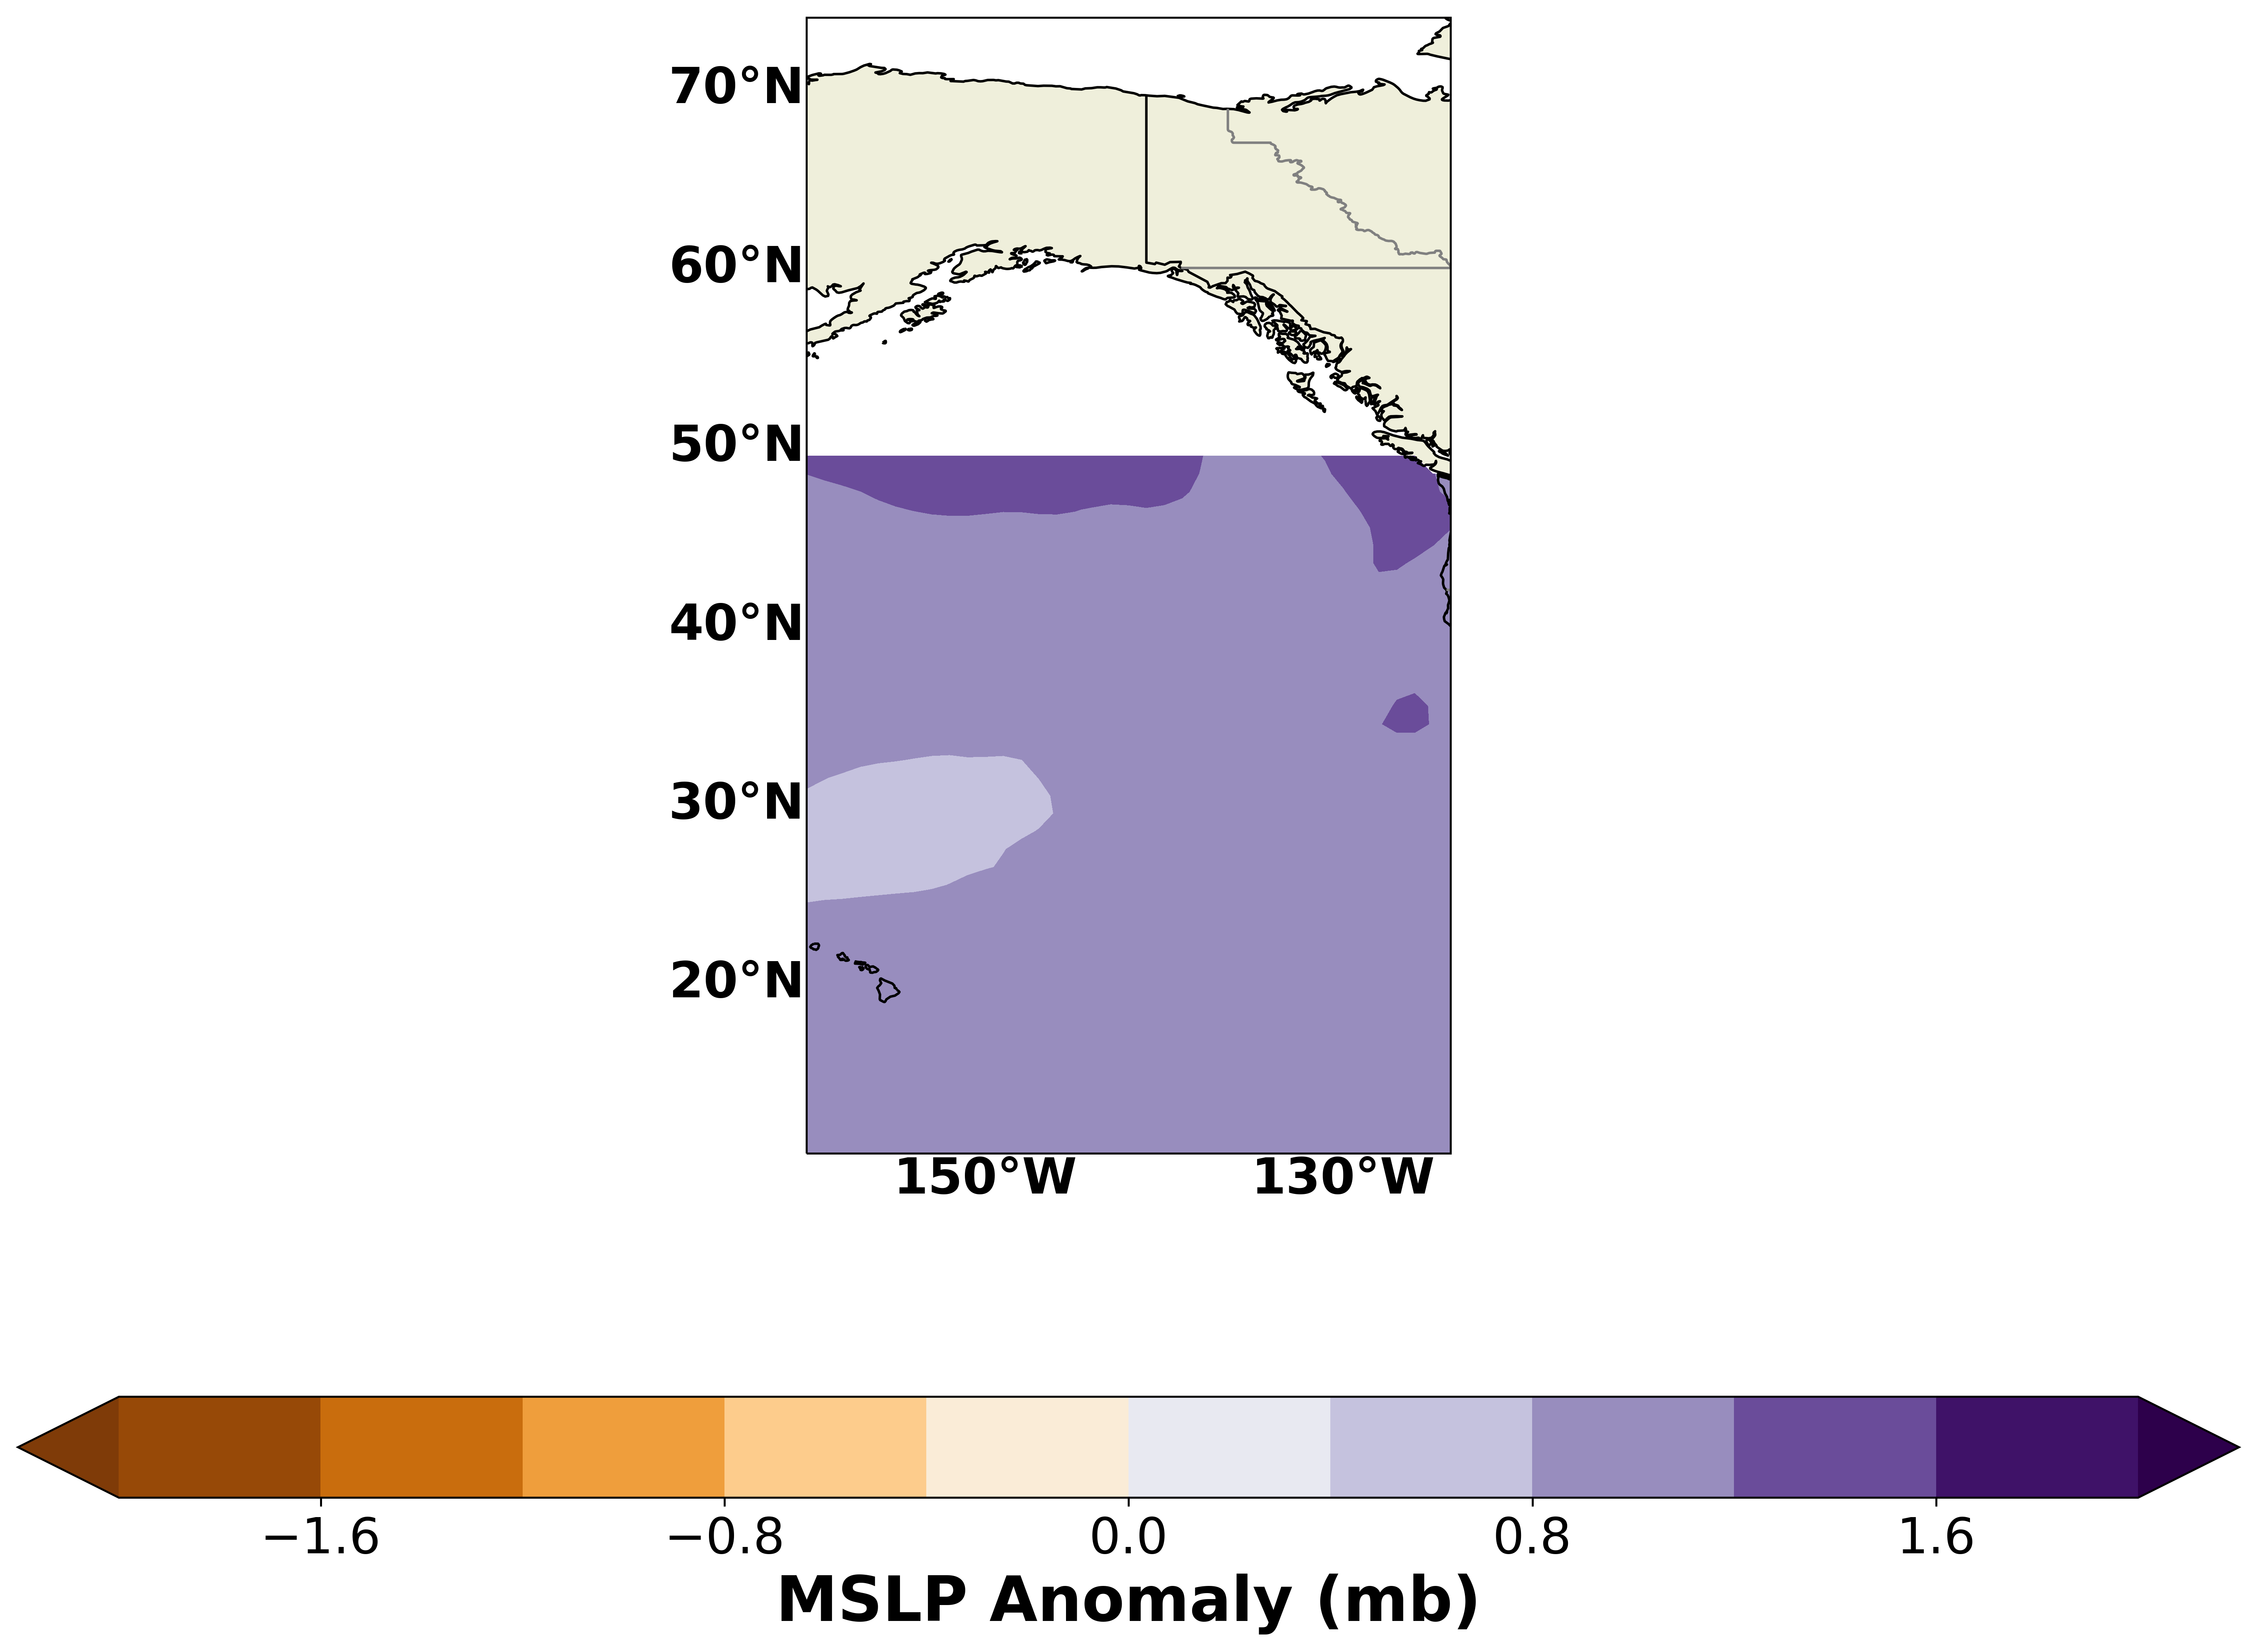

In [55]:
#mslp = np.reshape(Dataset(f1).variables['PSL'][:,120:,:,:],[48600,118,95])
conlevels = np.linspace(-2,2,11)
zconlevels = [2.228,1000]
clevs = np.linspace(-30,30,num=16)

figure(num=None, figsize=(16, 12), dpi=450, facecolor='w', edgecolor='k')
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude= -102.5,globe=None))
colormap = plt.cm.get_cmap('PuOr') 

djftemp = (happitemp[11,:,:]+happitemp[0,:,:]+happitemp[1,:,:])/3
plt.contourf(lon[200:237],lat[100:140],djftemp[100:140,200:237],conlevels,
			transform=ccrs.PlateCarree(), extend = 'both', cmap=colormap)

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
states_provinces = cfeature.NaturalEarthFeature(
		category='cultural',
		name='admin_1_states_provinces_lines',
		scale='50m',
		facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
ax.add_feature(states_provinces, edgecolor='gray')

cbar = plt.colorbar(orientation='horizontal')
cbar.ax.set_xlabel('MSLP Anomaly (mb)', fontsize = 25,rotation=0,weight='bold')
cbar.ax.tick_params(labelsize=20) 

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
				  linewidth=0, color='gray', alpha=0.5)
gl.xlabel_style = {'size': 20, 'weight': 'bold'}
gl.ylabel_style = {'size': 20, 'weight': 'bold'}
#gl.xlocator = ticker.FixedLocator([-135,-120])
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = matplotlib.ticker.FixedLocator([-190,-170,-150,-130,-110])
#gl.ylocator = matplotlib.ticker.FixedLocator([30,40,50,60,70])
#ax.clabel(cs,[-30,-26,-22,-18,-14,-10,-6,-2,2,6,10,14,18,22,26,30], inline=True, fmt=fmt, fontsize=10)
ax.set_ylim(top=74)

plt.plot()
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [22]:
files1 = sorted([I for I in glob.glob('/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/month_1/SST/b.e21.BHISTsmbb*200001-200912.nc')])
files2 = sorted([I for I in glob.glob('/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/month_1/SST/b.e21.BHISTsmbb*201001-201412.nc')])
len(files1)
T = np.zeros([50,156,192,288])
i = 0
while i < 50:
    T00 = Dataset(files1[i]).variables['SST'][84:,:,:]
    T10 = Dataset(files1[i]).variables['SST'][:]
    T[i,:,:,:] = np.concatenate([T00,T10],axis=0)
    i+=1


In [24]:
files1 = sorted([I for I in glob.glob('/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/month_1/SST/b.e21.BSSP370smbb*208501-209412.nc')])
files2 = sorted([I for I in glob.glob('/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/month_1/SST/b.e21.BSSP370smbb*209501-210012.nc')])
len(files1)
T = np.zeros([50,156,192,288])
i = 0
while i < 50:
    T00 = Dataset(files1[i]).variables['SST'][84:,:,:]
    T10 = Dataset(files1[i]).variables['SST'][:]
    T[i,:,:,:] = np.concatenate([T00,T10],axis=0)
    i+=1

In [6]:
x = Dataset('/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/month_1/SST/b.e21.BSSP370smbb.f09_g17.LE2-1301.020.cam.h0.SST.209501-210012.nc').variables['SST'][:]
lat = Dataset('/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/month_1/SST/b.e21.BSSP370smbb.f09_g17.LE2-1301.020.cam.h0.SST.209501-210012.nc').variables['lat'][:]
lon = Dataset('/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/month_1/SST/b.e21.BSSP370smbb.f09_g17.LE2-1301.020.cam.h0.SST.209501-210012.nc').variables['lon'][:]
x.shape

(72, 192, 288)

In [19]:
dec = np.linspace(12,156,13).astype(int) - 1
jan = np.linspace(12,156,13).astype(int) - 12
feb = np.linspace(12,156,13).astype(int) - 11


In [23]:
histdec = np.mean(T[:,dec,:,:],axis=(0,1))
histjan = np.mean(T[:,jan,:,:],axis=(0,1))
histfeb = np.mean(T[:,feb,:,:],axis=(0,1))


In [25]:
ssp370dec = np.mean(T[:,dec,:,:],axis=(0,1))
ssp370jan = np.mean(T[:,jan,:,:],axis=(0,1))
ssp370feb = np.mean(T[:,feb,:,:],axis=(0,1))

/glade/work/timothyh/miniconda3/envs/analysis/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/timothyh/miniconda3/envs/analysis/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


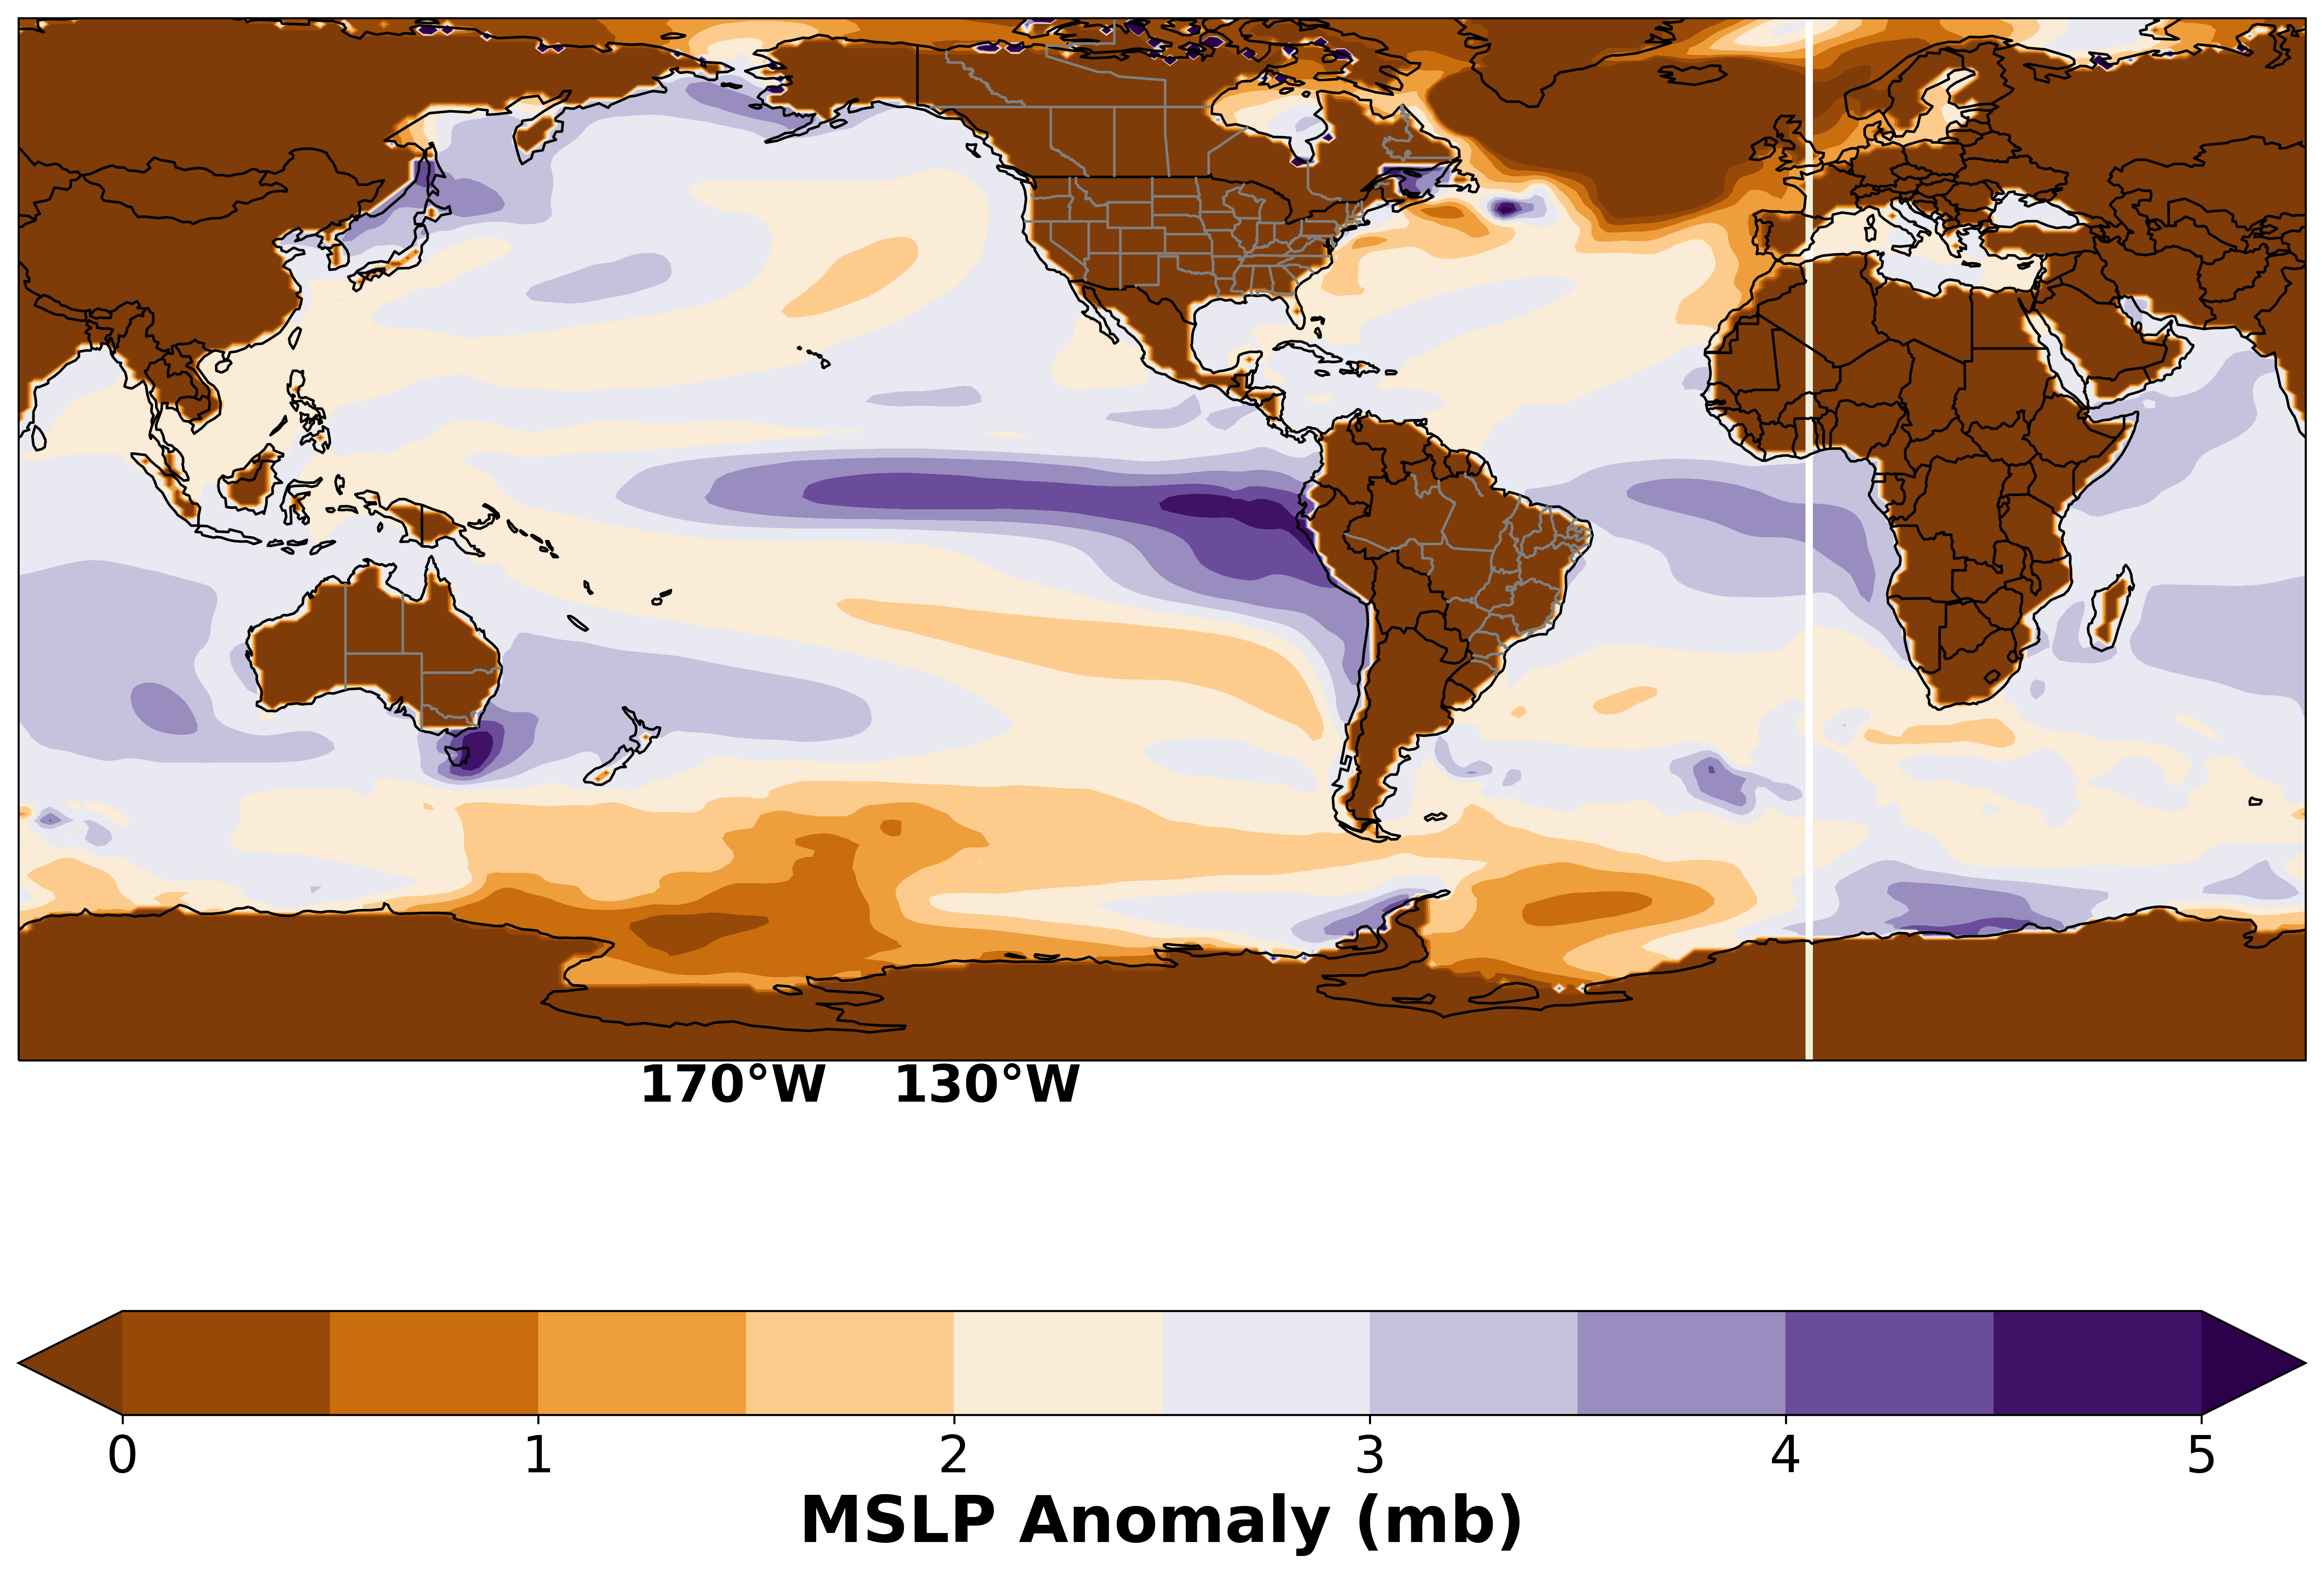

In [30]:
conlevels = np.linspace(0,5,11)
zconlevels = [2.228,1000]
clevs = np.linspace(-30,30,num=16)

figure(num=None, figsize=(16, 12), dpi=450, facecolor='w', edgecolor='k')
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude= -102.5,globe=None))
colormap = plt.cm.get_cmap('PuOr') 

a = ((ssp370dec-histdec)+(ssp370jan-histjan)+(ssp370feb-histfeb))/3
plt.contourf(lon[:],lat[:],a,conlevels,
			transform=ccrs.PlateCarree(), extend = 'both', cmap=colormap)

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
states_provinces = cfeature.NaturalEarthFeature(
		category='cultural',
		name='admin_1_states_provinces_lines',
		scale='50m',
		facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
ax.add_feature(states_provinces, edgecolor='gray')

cbar = plt.colorbar(orientation='horizontal')
cbar.ax.set_xlabel('MSLP Anomaly (mb)', fontsize = 25,rotation=0,weight='bold')
cbar.ax.tick_params(labelsize=20) 

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
				  linewidth=0, color='gray', alpha=0.5)
gl.xlabel_style = {'size': 20, 'weight': 'bold'}
gl.ylabel_style = {'size': 20, 'weight': 'bold'}
#gl.xlocator = ticker.FixedLocator([-135,-120])
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = matplotlib.ticker.FixedLocator([-190,-170,-150,-130,-110])
gl.ylocator = matplotlib.ticker.FixedLocator([30,40,50,60,70])
#ax.clabel(cs,[-30,-26,-22,-18,-14,-10,-6,-2,2,6,10,14,18,22,26,30], inline=True, fmt=fmt, fontsize=10)
ax.set_ylim(top=74)

plt.plot()
warnings.filterwarnings("ignore", category=DeprecationWarning)
